## Final Project - Divorce & marriage
Aviv, Elay and Ron

installations

In [1]:
! pip install python-louvain

In [2]:
import pandas as pd
import networkx as nx
import collections
import numpy as np
from functools import partial
import collections.abc
import operator
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import scipy.stats as stats
from itertools import combinations
import statistics
from sklearn.preprocessing import MinMaxScaler

In [3]:
plt.figure(figsize=(30,20))
np.random.seed(7)

<Figure size 3000x2000 with 0 Axes>

In [4]:
!apt-get install python9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python9


TMFG Filtering - topcorr

In [5]:
def _calculate_new_faces(faces, new, old_set):
    """
    Calculates the new triangular faces for the network when we
    add in new
    Parameters
    -----------
    faces : list
        a list of the faces present in the graph
    new : int
        the node id that is being added to the face
    old_set : set
        the old face that the node is being added to
    Returns
    -------
    None
    """
    faces.remove(frozenset(old_set))

    faces.add(frozenset([new, old_set[1], old_set[0]]))
    faces.add(frozenset([new, old_set[0], old_set[2]]))
    faces.add(frozenset([new, old_set[1], old_set[2]]))

def _add_triangular_face(G, new, old_set, C, faces):
    """
    Adds a new triangle to the networkx graph G
    Parameters
    -----------
    G : networkx graph
        the networkx graph to add the new face to
    new : int
        the node id that is being added to the face
    C : array_like
        correlation matrix
    old_set : set
        the old face that the node is being added to
    faces : list
        a list of the faces present in the graph
    Returns
    -------
    None
    """

    if len(old_set) > 3:
        raise ValueError("Old set is not the right size!")
    for j in old_set:
        G.add_edge(new, j, weight=C[new, j])


In [6]:
def tmfg(corr, absolute=False, threshold_mean=True):
    """
    Constructs a TMFG from the supplied correlation matrix
    Parameters
    -----------
    corr : array_like
        p x p matrix - correlation matrix
    absolute : bool
        whether to use the absolute correlation values for chooisng weights or normal ones
    threshold_mean : bool
        this will discard all correlations below the mean value when selecting the first 4
        vertices, as in the original implementation
    Returns
    -------
    networkx graph
        The Triangular Maximally Filtered Graph
    """
    p = corr.shape[0]

    if absolute:
        weight_corr = np.abs(corr)
    else:
        weight_corr = corr

    # Find the 4 most central vertices
    new_weight = weight_corr.copy()
    if threshold_mean:
        new_weight[new_weight < new_weight.mean()] = 0
    degree_centrality = new_weight.sum(axis=0)
    ind = np.argsort(degree_centrality)[::-1]
    starters = ind[0:4]
    starters_set = set(starters)
    not_in = set(range(p))
    not_in = not_in.difference(starters_set)
    G = nx.Graph()
    G.add_nodes_from(range(p))

    # Add the tetrahedron in
    faces = set()
    _add_triangular_face(G, ind[0], set([ind[1], ind[3]]), corr, faces)
    _add_triangular_face(G, ind[1], set([ind[2], ind[3]]), corr, faces)
    _add_triangular_face(G, ind[0], set([ind[2], ind[3]]), corr, faces)
    _add_triangular_face(G, ind[2], set([ind[1], ind[3]]), corr, faces)

    faces.add(frozenset([ind[0], ind[1], ind[3]]))
    faces.add(frozenset( [ind[1], ind[2], ind[3]] ))
    faces.add(frozenset([ind[0], ind[2], ind[3]]))
    faces.add(frozenset([ind[0], ind[1], ind[2]]))

    while len(not_in) > 0:
        #to_check = permutations(starters_set, 3)

        max_corr = -np.inf
        max_i = -1
        nodes_correlated_with = None
        not_in_arr = np.array(list(not_in))

        # Find the node most correlated with the faces in the TMFG currently
        for ind in faces:
            ind = list(ind)
            ind_arr = np.array(ind)
            most_related = weight_corr[ind_arr, :][:, not_in_arr].sum(axis=0)
            # print(most_related)
            ind_2 = np.argsort(most_related)[::-1]
            curr_corr = most_related[ind_2[0]]

            if curr_corr > max_corr:
                max_corr = curr_corr
                max_i = not_in_arr[[ind_2[0]]]
                nodes_correlated_with = ind
        # if isinstance(max_i, int):
        #   print("intheree")
        #   max_i = [max_i]
        starters_set = starters_set.union(set(max_i))
        not_in = not_in.difference(starters_set)
        _add_triangular_face(G, max_i[0], nodes_correlated_with, corr, faces)
        _calculate_new_faces(faces, max_i[0], nodes_correlated_with)

    return G

# General functions of graph creating, analysis and visualization

In [7]:
def create_network(data):
  # creat graphs using pearson corr matrix, nosing and tmfg filter as described in details in the report
  corr_mati=data.corr(method="pearson")
  if corr_mati.isna().sum().sum():
    noise = np.random.normal(0,1, corr_mati.shape)
    noise = np.clip(noise, -1, 1)
    corr_mati = corr_mati.fillna(0.0)
    corr_mati = corr_mati.to_numpy()
    corr_with_noise = corr_mati + noise
    tmfg_G = tmfg(corr_with_noise)
  else:
    corr_mati = corr_mati.to_numpy()
    tmfg_G = tmfg(corr_mati)
  return tmfg_G

In [8]:
def prepre_G(data,coloring = None,far_layout=False,multi_k = 1):
  # creates the graph and makes the visualization
  tmfg_G = create_network(data)
  # plt.figure(figsize=(20,10))
  plt.figure(figsize=(20,10))
  if not far_layout:
    pos = nx.spring_layout(tmfg_G,k=multi_k/(len(tmfg_G.nodes())),seed=7)  # Laylot optimaztion
  else:
    pos = nx.spring_layout(tmfg_G,seed=5)
  print(f"nodes:{len(tmfg_G.nodes())}")
  print(f"edges:{len(tmfg_G.edges())}")
#   print(f"range: [{min(weights)},{max(weights)}]")
#   colors = ["gray" if x not in larger_weights else 'r' for x in weights]
  if coloring is not None:
    nx.draw_networkx(tmfg_G, pos, with_labels=True,node_color= coloring, node_size=550,cmap='Set2')
  else:
    nx.draw_networkx(tmfg_G, pos, with_labels=True, node_size=550)

  plt.show(tmfg_G)
  return

In [9]:
def partition_dict_to_list(partitions):
  """
    An auxilary function to map a dict of partitions to a list of partitions.
    -----------
    partitions : dict
        A dictionary where the key represent a node aand value the index of its community
    Returns
    -------
    A list of communities where each community is a set which includes all the
    nodes that are part of this community
  """
  num_partitions = max([v for v in partitions.values()])
  res = [set() for _ in range(num_partitions+1)]
  for k,v in partitions.items():
    try:
      res[v].add(k)
    except IndexError:
      print(v)
  return res

In [10]:
def get_sub_nodes(G, partiton_list):
  # culculate the subset of the questions as described in details in the report
  centrality = nx.degree_centrality(G)
  eigenvector = list(nx.eigenvector_centrality(G, max_iter=200).values())
  norm_eig = [(i- min(eigenvector))/(max(eigenvector) - min(eigenvector)) for i in eigenvector]

  mininal_DC_groups = []
  for group_indexes in partiton_list:
    group_lost = list(group_indexes)
    mes_group = [norm_eig[i] for i in group_lost]
    mes_group_index = [j for j in group_lost]
    argmin_group = np.argmin(mes_group)
    mininal_DC_groups.append(mes_group_index[argmin_group])
  return mininal_DC_groups

In [11]:
def get_sub_nodes1(G, partiton_list):
  # culculate the subset of the questions as described in details in the report
  centrality = nx.degree_centrality(G)
  eigenvector = list(nx.eigenvector_centrality(G, max_iter=200).values())
  norm_eig = [(i- min(eigenvector))/(max(eigenvector) - min(eigenvector)) for i in eigenvector]
  betweenness = nx.betweenness_centrality(G)
  maxmial_DC_groups = []
  for group_indexes in partiton_list:
    group_lost = list(group_indexes)
    mes_group = [eigenvector[i] for i in group_lost]
    mes_group_index = [j for j in group_lost]
    argmax_group = np.argmax(mes_group)
    maxmial_DC_groups.append(mes_group_index[argmax_group])
  return maxmial_DC_groups

In [12]:
def generate_modularity_values(G, epochs=300, seed=323):
  """
    Constructs a sample of modularity values based on a sample of different
    partitions of the network to two communities based on the Kernighan - Lin Algorithm.
    Parameters
    -----------
    G : networkx graph
    epochs : int
        The size of the sample
    seed : int
        The number of the random seed.
    Returns
    -------
    A list of modularity values
    """
  np.random.seed(seed)
  modularity_values = []
  for _ in range(epochs):
    generated_communities = nx.community.kernighan_lin_bisection(G)
    modularity_val = nx.community.modularity(G, generated_communities)
    modularity_values.append(modularity_val)
  return modularity_values

# Part 1

# Create the data

In [13]:
data = pd.read_csv("divorce_data.csv", delimiter=';')
labels = data["Divorce"]

### Create and analysis of network of answers of all couples

nodes:54
edges:156


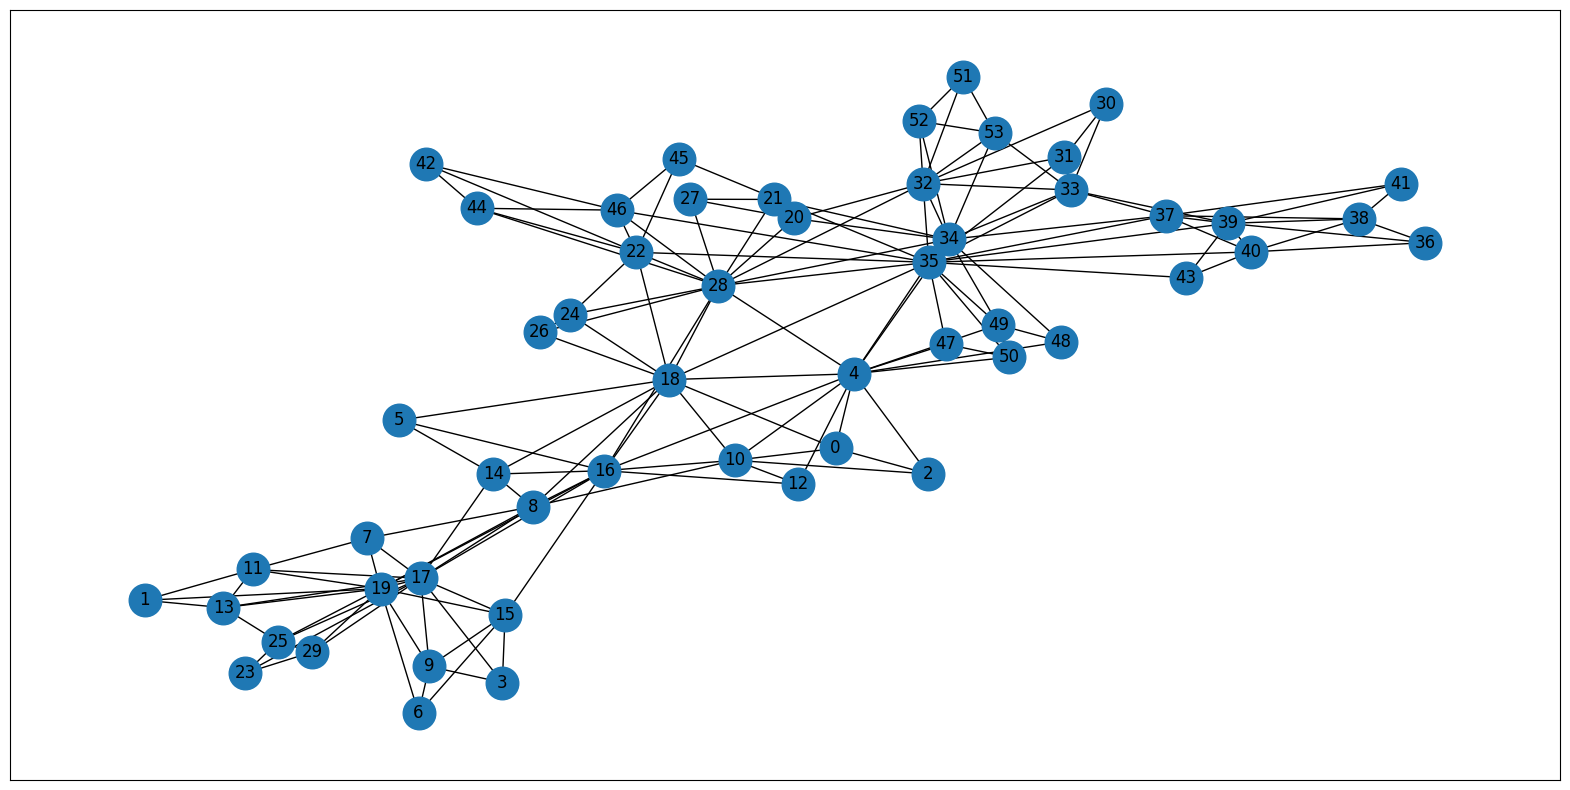

In [14]:
# both divorced and married
d = data.drop("Divorce", axis = 1)
full_G = create_network(d)
prepre_G(d)

The modularity of the network of the answers of married couples with louvain communities is:  0.5546104536489151
nodes:54
edges:156


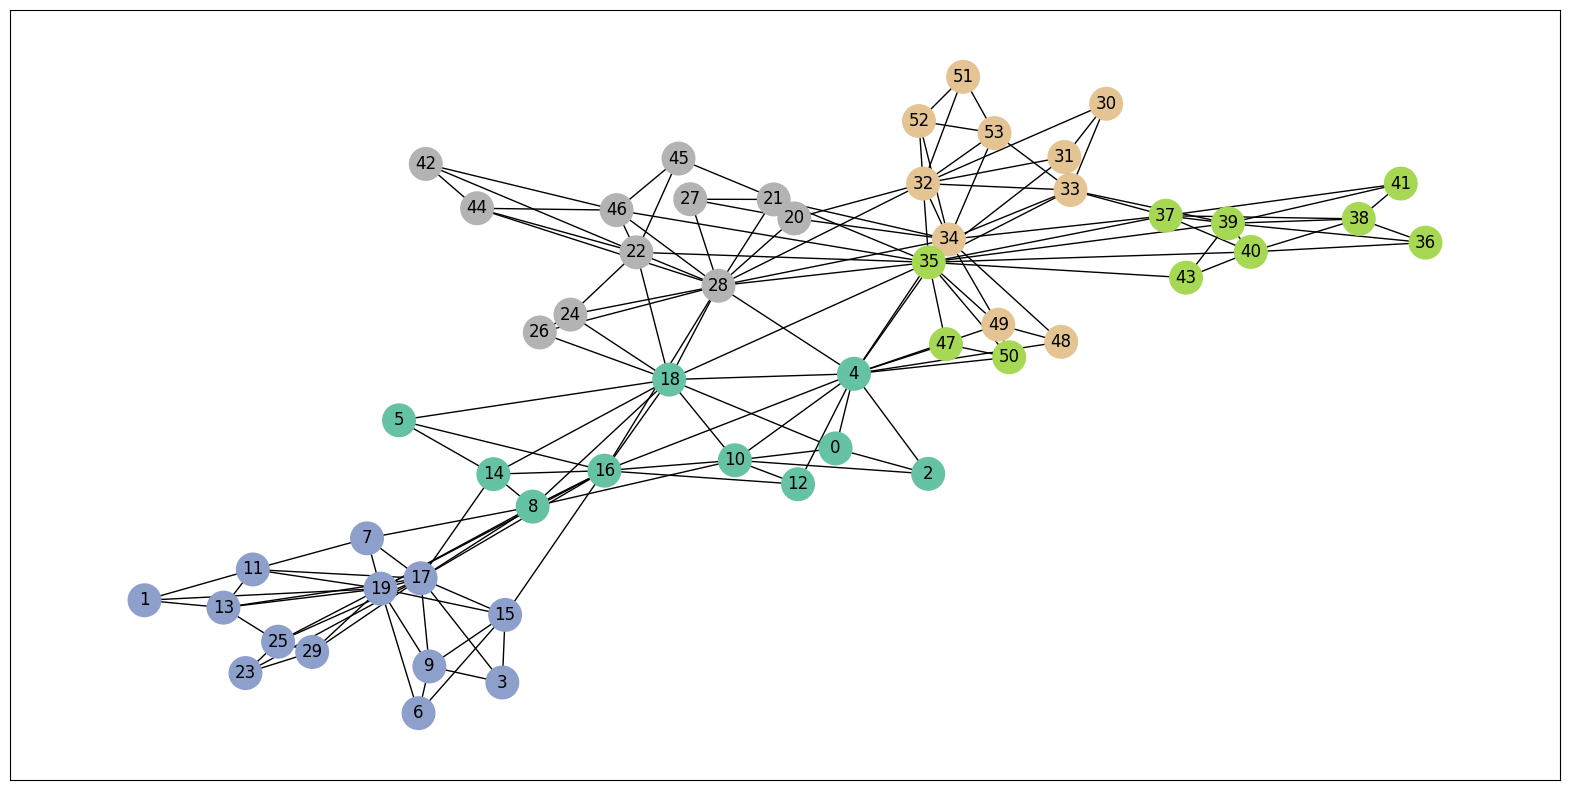

In [15]:
# calculate partitons
all_partiation = community_louvain.best_partition(full_G,weight='None')
print(f'The modularity of the network of the answers of married couples with louvain communities is: ',community_louvain.modularity(all_partiation,full_G,weight='None'))
community_values_all =[all_partiation.get(node) for node in full_G.nodes()]
prepre_G(d,community_values_all)

# calculate sub question
partiton_list_all = partition_dict_to_list(all_partiation)
sub1 = get_sub_nodes(full_G, partiton_list_all)

### Create and analysis of network of answers of divorce couples

nodes:54
edges:156


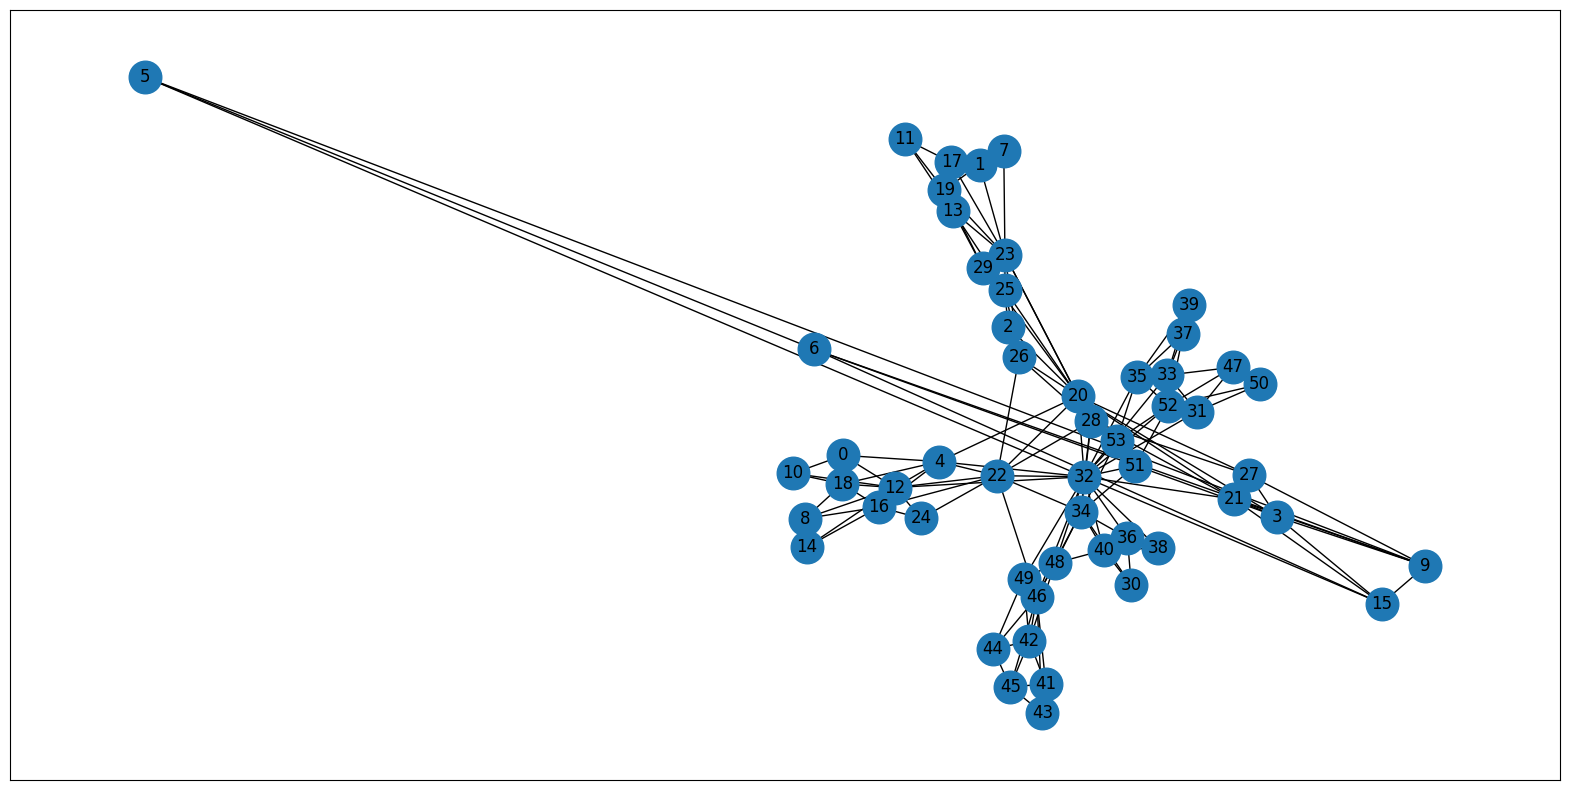

In [16]:
# only divored
only_divored = data[data["Divorce"]==1]
only_divored = only_divored.drop("Divorce", axis = 1)
prepre_G(only_divored,far_layout=True)

The modularity of the network of the answers of divorced couples with louvain communities is:  0.6181788297172912
nodes:54
edges:156


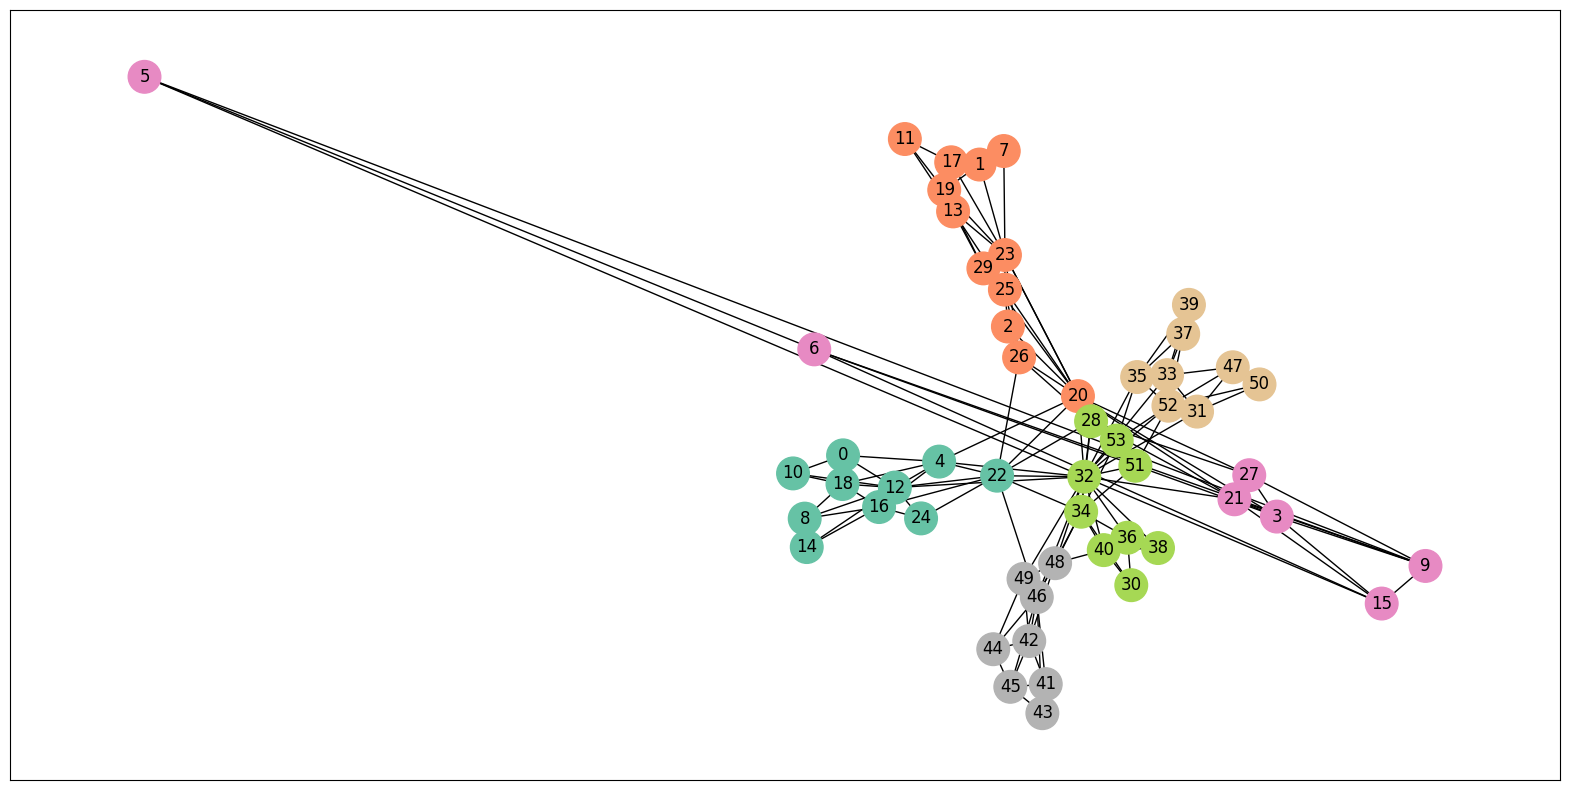

In [17]:
# calculate sub question
divorced_G = create_network(only_divored)
divorced_partiation = community_louvain.best_partition(divorced_G,weight='None')
print(f'The modularity of the network of the answers of divorced couples with louvain communities is: ',community_louvain.modularity(divorced_partiation,divorced_G,weight='None'))

community_values_divorced =[divorced_partiation.get(node) for node in divorced_G.nodes()]
prepre_G(only_divored,community_values_divorced,True)

# calculate sub question
partiton_list_div = partition_dict_to_list(divorced_partiation)
sub2 = get_sub_nodes(divorced_G, partiton_list_div)

### Create and analysis of network of answers of married couples

nodes:54
edges:156


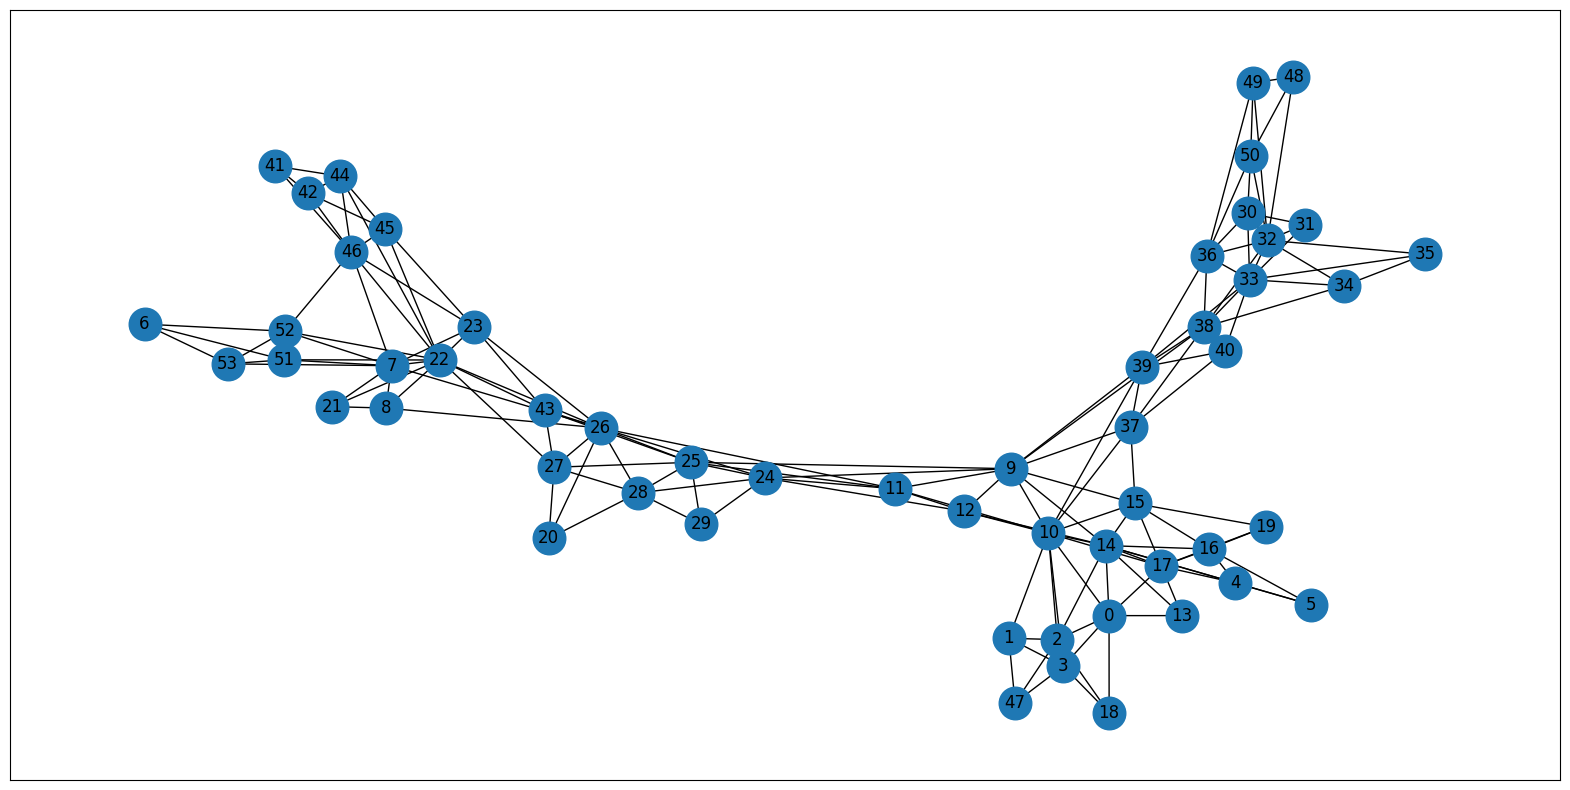

In [18]:
# only married
only_married = data[data["Divorce"]==0]
only_married = only_married.drop("Divorce", axis = 1)
prepre_G(only_married)

The modularity of the network of the answers of married couples with louvain communities is:  0.6267052925706772
nodes:54
edges:156


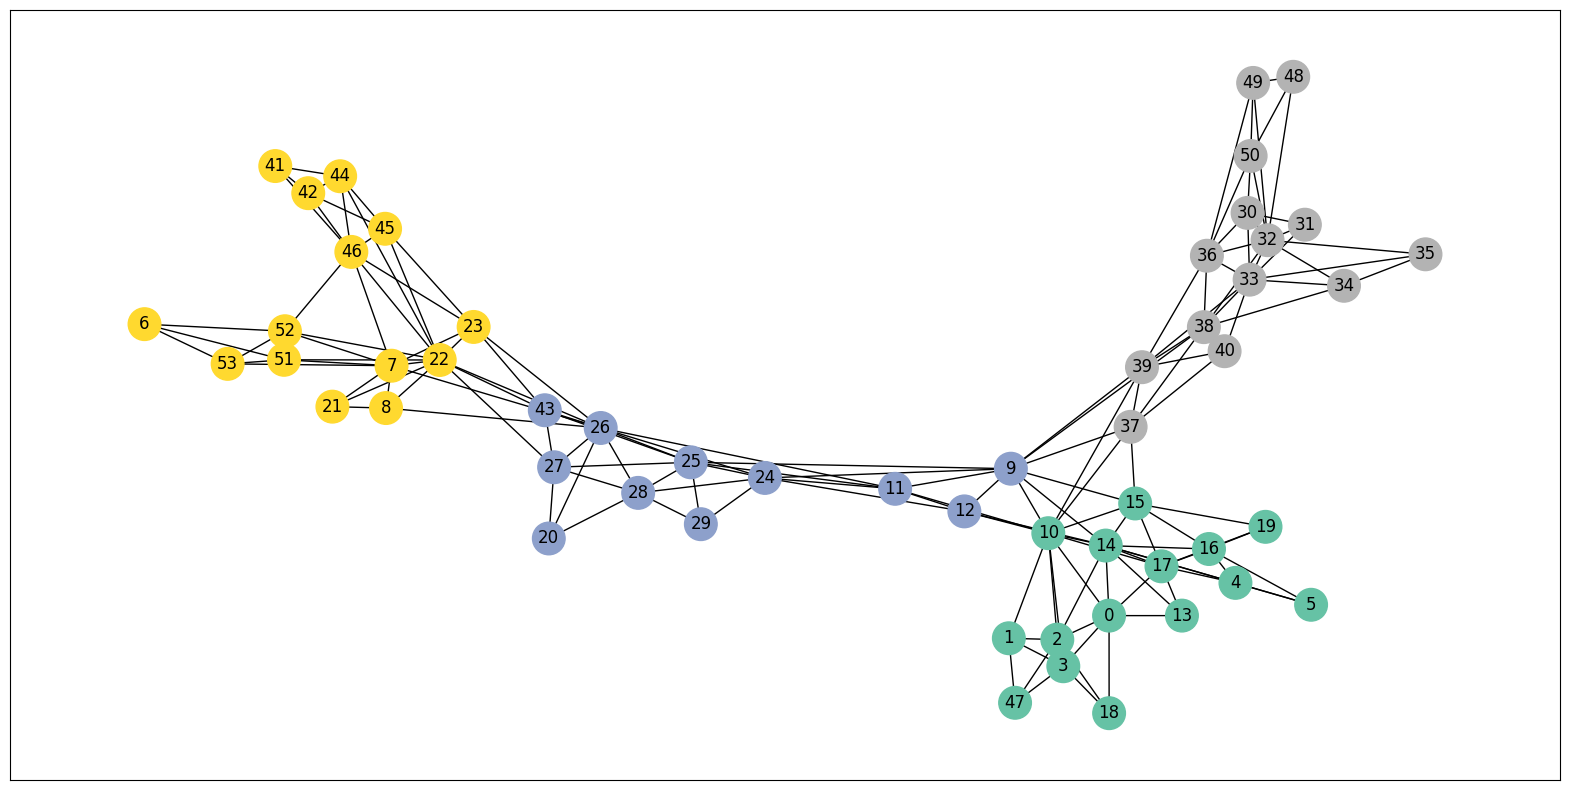

In [19]:
# louvain and modularity of married
married_G = create_network(only_married)
married_partiation = community_louvain.best_partition(married_G,weight='None')
community_values_married =[married_partiation.get(node) for node in married_G.nodes()]
print(f'The modularity of the network of the answers of married couples with louvain communities is: ',community_louvain.modularity(married_partiation,married_G,weight='None'))
prepre_G(only_married,community_values_married)

# calculate sub question
partiton_list_mar = partition_dict_to_list(married_partiation)
sub3 = get_sub_nodes(married_G, partiton_list_mar)

## Calculate graph measurements

In [20]:
# Computing global measurements for our networks

results = {
    "ACC": [nx.average_clustering(divorced_G),
            nx.average_clustering(married_G),
            nx.average_clustering(full_G)],
    "Modularity of Louvain Communities": [community_louvain.modularity(divorced_partiation,divorced_G,weight='None'),
                                          community_louvain.modularity(married_partiation,married_G,weight='None'),
                                          community_louvain.modularity(all_partiation,full_G,weight='None')],
    "ASPL": [nx.average_shortest_path_length(divorced_G),
             nx.average_shortest_path_length(married_G),
             nx.average_shortest_path_length(full_G)],
    "Average Group Betweeness Centrality": [statistics.mean(nx.group_betweenness_centrality(divorced_G,partition_dict_to_list(divorced_partiation))),
                              statistics.mean(nx.group_betweenness_centrality(married_G,partition_dict_to_list(married_partiation))),
                              statistics.mean(nx.group_betweenness_centrality(full_G,partition_dict_to_list(all_partiation)))],
    "Average Degree": [statistics.mean([divorced_G.degree(n) for n in divorced_G.nodes()]),
                       statistics.mean([married_G.degree(n) for n in married_G.nodes()]),
                       statistics.mean([full_G.degree(n) for n in full_G.nodes()])],
    "Average Maximal Number of Cliques per Node": [statistics.mean([sum(1 for c in nx.find_cliques(divorced_G))]),
                                                   statistics.mean([sum(1 for c in nx.find_cliques(married_G))]),
                                                   statistics.mean([sum(1 for c in nx.find_cliques(full_G))])],
    "Average Connectivity": [nx.average_node_connectivity(divorced_G),
                             nx.average_node_connectivity(married_G),
                             nx.average_node_connectivity(full_G)],
    "Average Degree Centrality": [statistics.mean([nx.degree_centrality(divorced_G)[i] for i in divorced_G.nodes()]),
                                  statistics.mean([nx.degree_centrality(married_G)[i] for i in married_G.nodes()]),
                                  statistics.mean([nx.degree_centrality(full_G)[i] for i in full_G.nodes()])],
    "Average Group Closeness Centrality": [statistics.mean([nx.group_closeness_centrality(divorced_G,partition) for partition in partition_dict_to_list(divorced_partiation)]),
                              statistics.mean([nx.group_closeness_centrality(married_G,partition) for partition in partition_dict_to_list(married_partiation)]),
                              statistics.mean([nx.group_closeness_centrality(full_G,partition) for partition in partition_dict_to_list(all_partiation)])],
    "Average Eigenvector Centrality": [statistics.mean([v for v in nx.eigenvector_centrality(divorced_G, max_iter=200).values()]),
                                       statistics.mean([v for v in nx.eigenvector_centrality(married_G, max_iter=200).values()]),
                                       statistics.mean([v for v in nx.eigenvector_centrality(full_G, max_iter=200).values()])]

}

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.columns = ["divorced", "married", "both married and divorced"]
results_df

divorced    married  \
ACC                                          0.695191   0.690423   
Modularity of Louvain Communities            0.618179   0.626705   
ASPL                                         2.983229   3.691824   
Average Group Betweeness Centrality          0.109033   0.138601   
Average Degree                               5.777778   5.777778   
Average Maximal Number of Cliques per Node  51.000000  51.000000   
Average Connectivity                         3.104822   3.104822   
Average Degree Centrality                    0.109015   0.109015   
Average Group Closeness Centrality           0.438760   0.348124   
Average Eigenvector Centrality               0.109909   0.115602   

                                            both married and divorced  
ACC                                                          0.728416  
Modularity of Louvain Communities                            0.554610  
ASPL                                                         2.929420  
Average Group Betweeness Centrality                          0.149760  
Average Degree                                               5.777778  
Average Maximal Number of Cliques per Node                  51.000000  
Average Connectivity                                         3.104822  
Average Degree Centrality                                    0.109015  
Average Group Closeness Centrality                           0.438563  
Average Eigenvector Centrality                               0.111869

## Creating community graphs and calculate measurements for all community in all graphs

0         1         2         3         4  \
Degree Centrality       0.444444  0.333333  0.555556  0.333333  0.444444   
Eigenvector Centrality  0.274746  0.209523  0.328839  0.216499  0.278191   
Betweeness Centrality   0.009259  0.000000  0.032407  0.000000  0.009259   

                               5         6         7         8         9  
Degree Centrality       0.666667  0.333333  0.444444  1.000000  0.777778  
Eigenvector Centrality  0.361393  0.219670  0.260444  0.480682  0.412882  
Betweeness Centrality   0.069444  0.000000  0.009259  0.333333  0.120370

nodes:10
edges:24


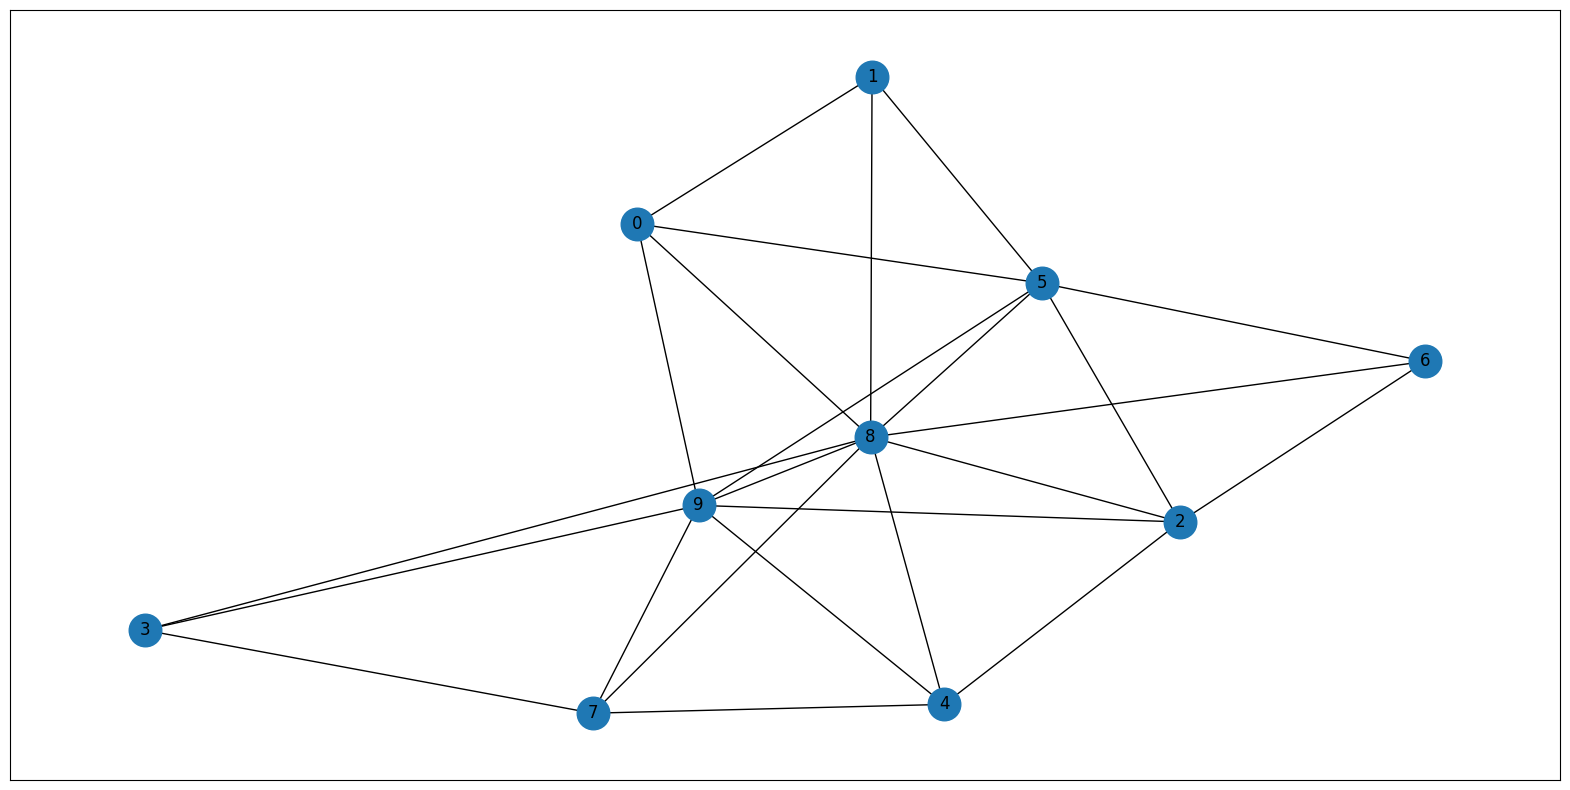

0         1         2         3         4   \
Degree Centrality       0.250000  0.250000  0.250000  0.333333  0.416667   
Eigenvector Centrality  0.168818  0.171547  0.171784  0.249320  0.261794   
Betweeness Centrality   0.000000  0.000000  0.000000  0.005051  0.023737   

                              5         6         7         8         9   \
Degree Centrality       0.416667  0.416667  0.500000  0.833333  0.833333   
Eigenvector Centrality  0.270153  0.272344  0.298102  0.446534  0.447929   
Betweeness Centrality   0.023232  0.025758  0.043939  0.288384  0.280808   

                              10        11        12  
Degree Centrality       0.250000  0.416667  0.333333  
Eigenvector Centrality  0.159474  0.264366  0.224705  
Betweeness Centrality   0.000000  0.025758  0.010606

nodes:13
edges:33


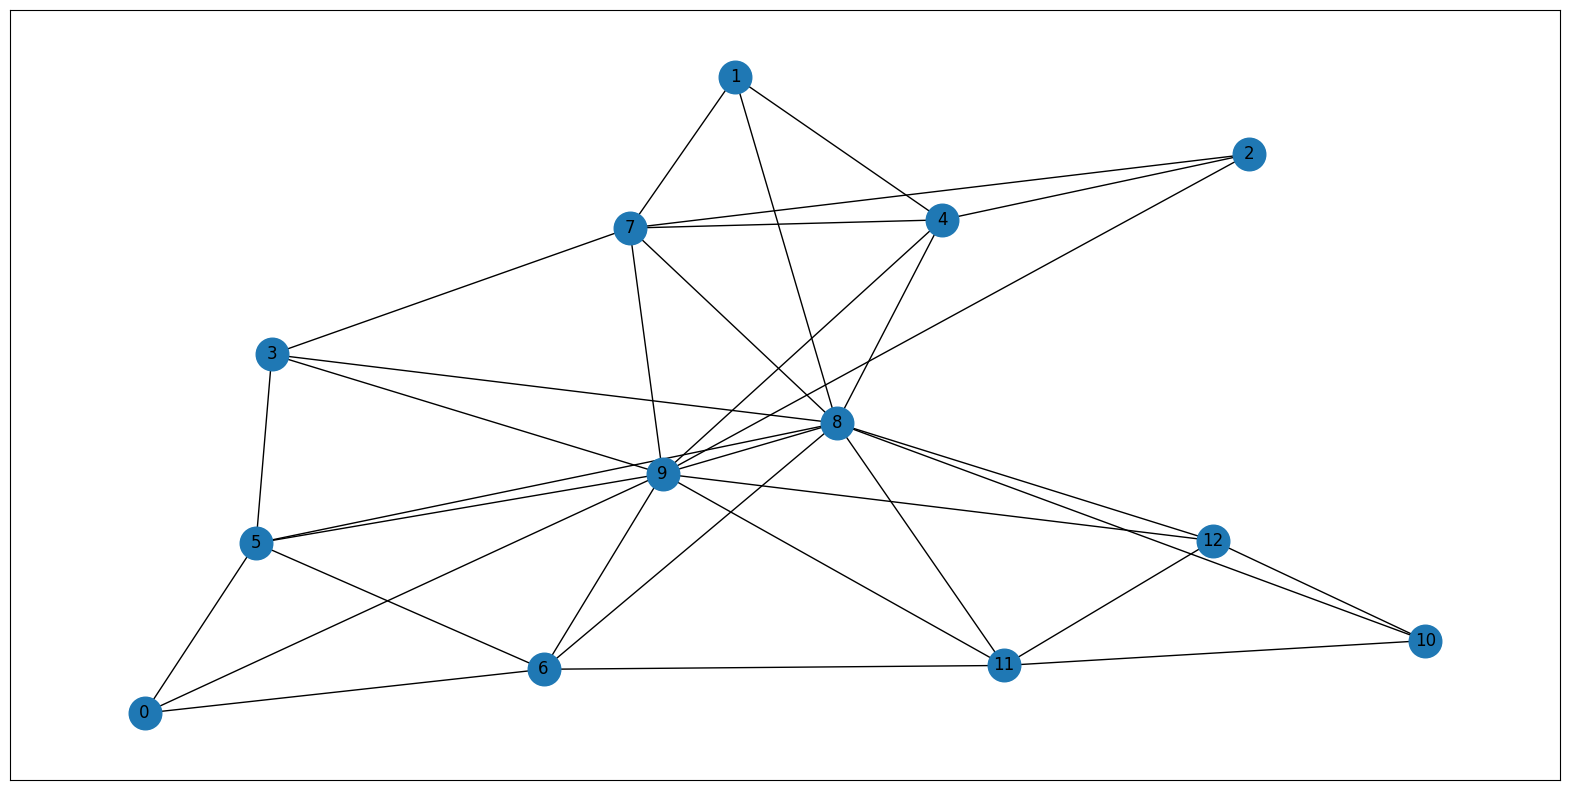

0         1         2         3         4  \
Degree Centrality       0.444444  0.444444  0.666667  0.777778  1.000000   
Eigenvector Centrality  0.260551  0.278919  0.362131  0.407448  0.481438   
Betweeness Centrality   0.009259  0.009259  0.069444  0.120370  0.333333   

                               5         6         7         8         9  
Degree Centrality       0.555556  0.333333  0.333333  0.333333  0.444444  
Eigenvector Centrality  0.336289  0.234966  0.207377  0.215757  0.259859  
Betweeness Centrality   0.032407  0.000000  0.000000  0.000000  0.009259

nodes:10
edges:24


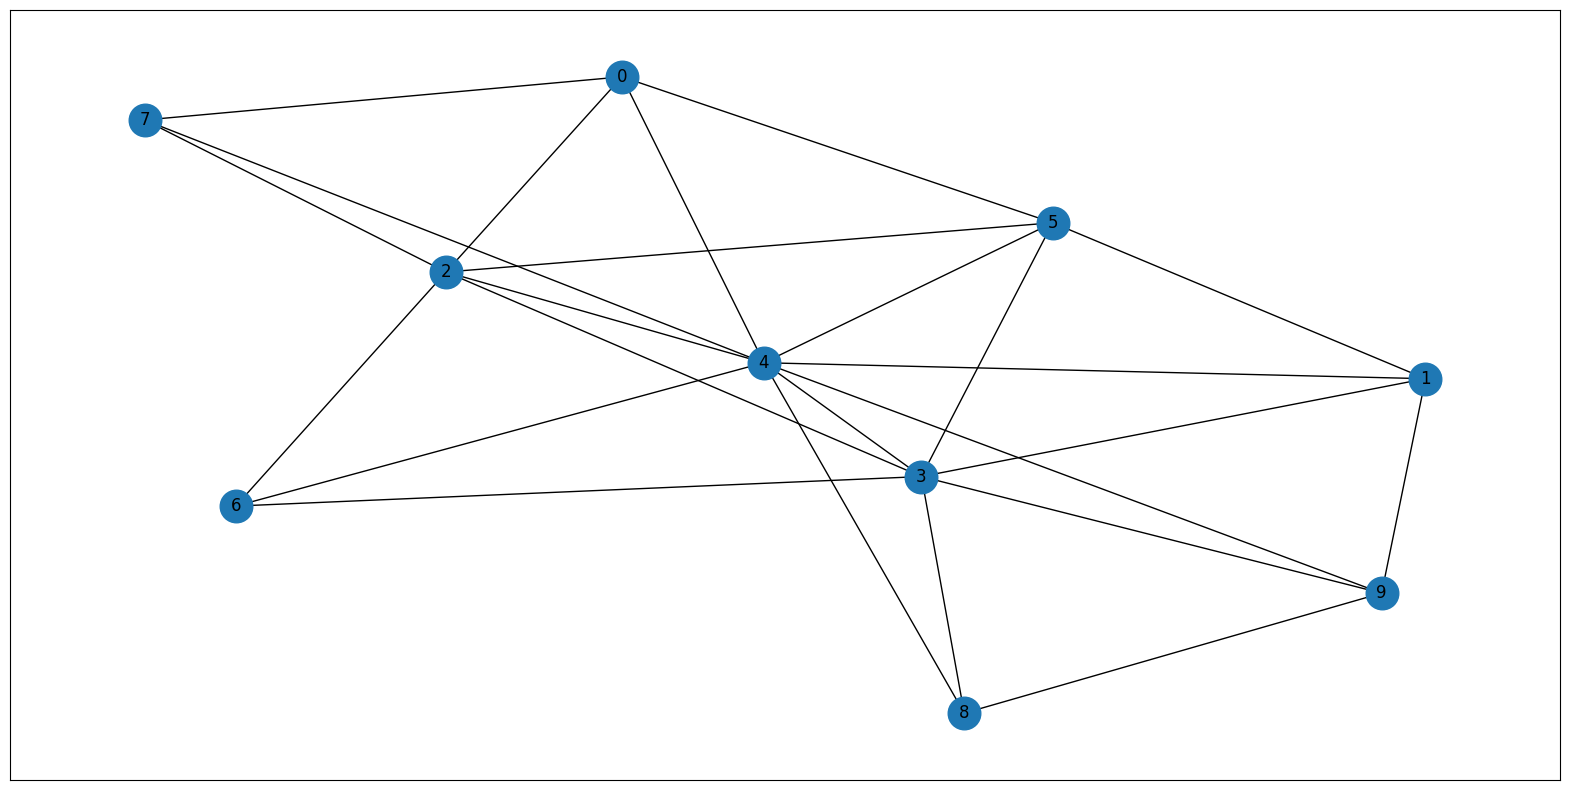

0         1         2         3         4  \
Degree Centrality       1.000000  0.444444  0.888889  0.333333  0.444444   
Eigenvector Centrality  0.479910  0.284931  0.448478  0.223827  0.267347   
Betweeness Centrality   0.319444  0.009259  0.185185  0.000000  0.009259   

                               5         6         7         8         9  
Degree Centrality       0.333333  0.444444  0.555556  0.444444  0.444444  
Eigenvector Centrality  0.199349  0.270062  0.314988  0.276013  0.278785  
Betweeness Centrality   0.000000  0.009259  0.032407  0.009259  0.009259

nodes:10
edges:24


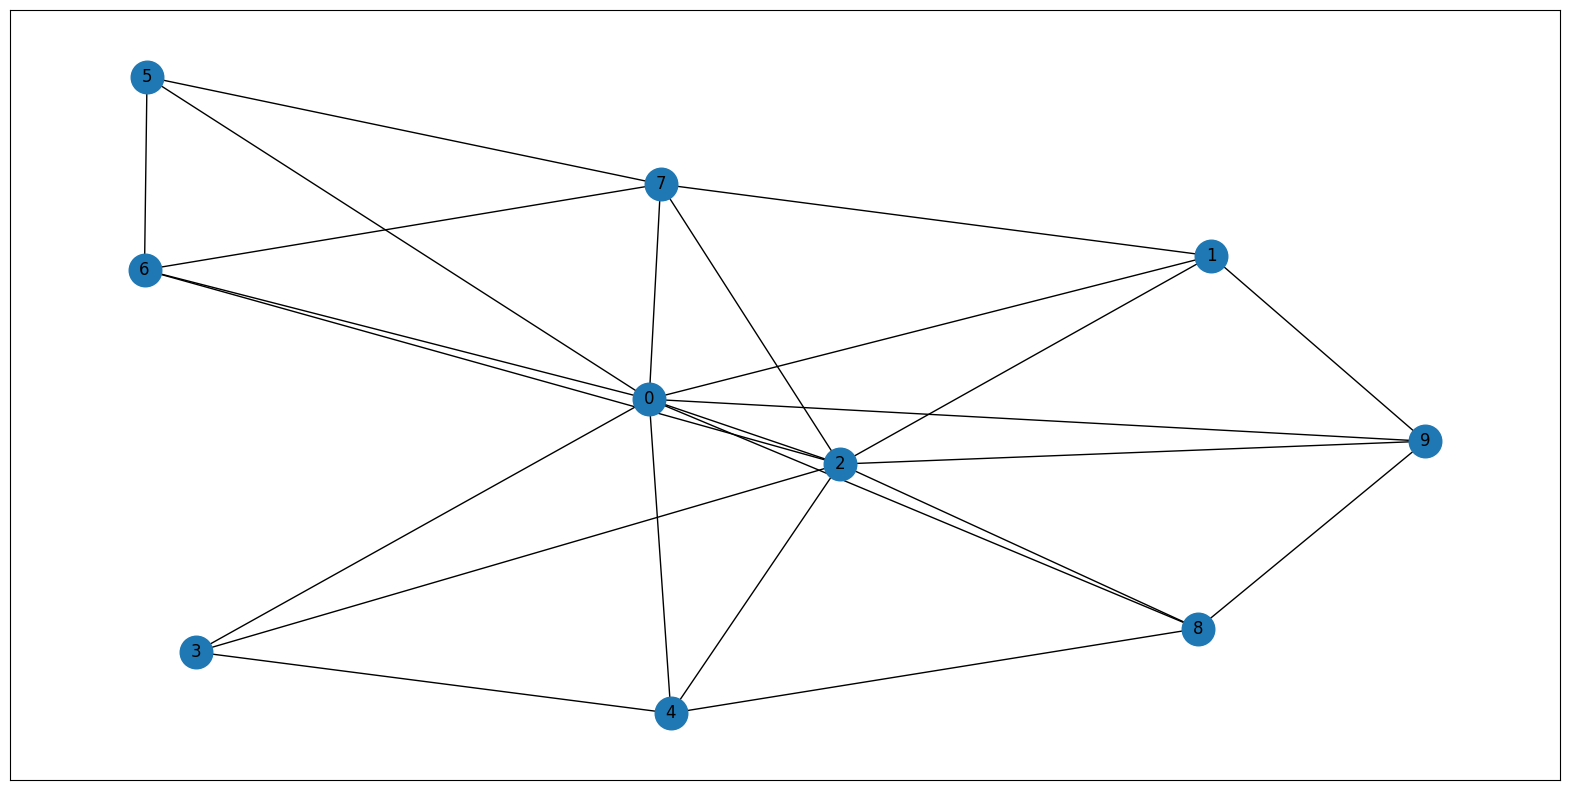

0         1         2         3         4   \
Degree Centrality       0.400000  0.400000  0.300000  0.600000  0.500000   
Eigenvector Centrality  0.229251  0.265781  0.188269  0.343077  0.299268   
Betweeness Centrality   0.007407  0.011111  0.000000  0.071852  0.034074   

                              5         6         7         8         9   \
Degree Centrality       0.500000  0.900000  0.300000  0.400000  0.300000   
Eigenvector Centrality  0.313024  0.460396  0.207724  0.253869  0.189134   
Betweeness Centrality   0.042222  0.302222  0.000000  0.007407  0.000000   

                             10  
Degree Centrality       0.80000  
Eigenvector Centrality  0.42518  
Betweeness Centrality   0.19037

nodes:11
edges:27


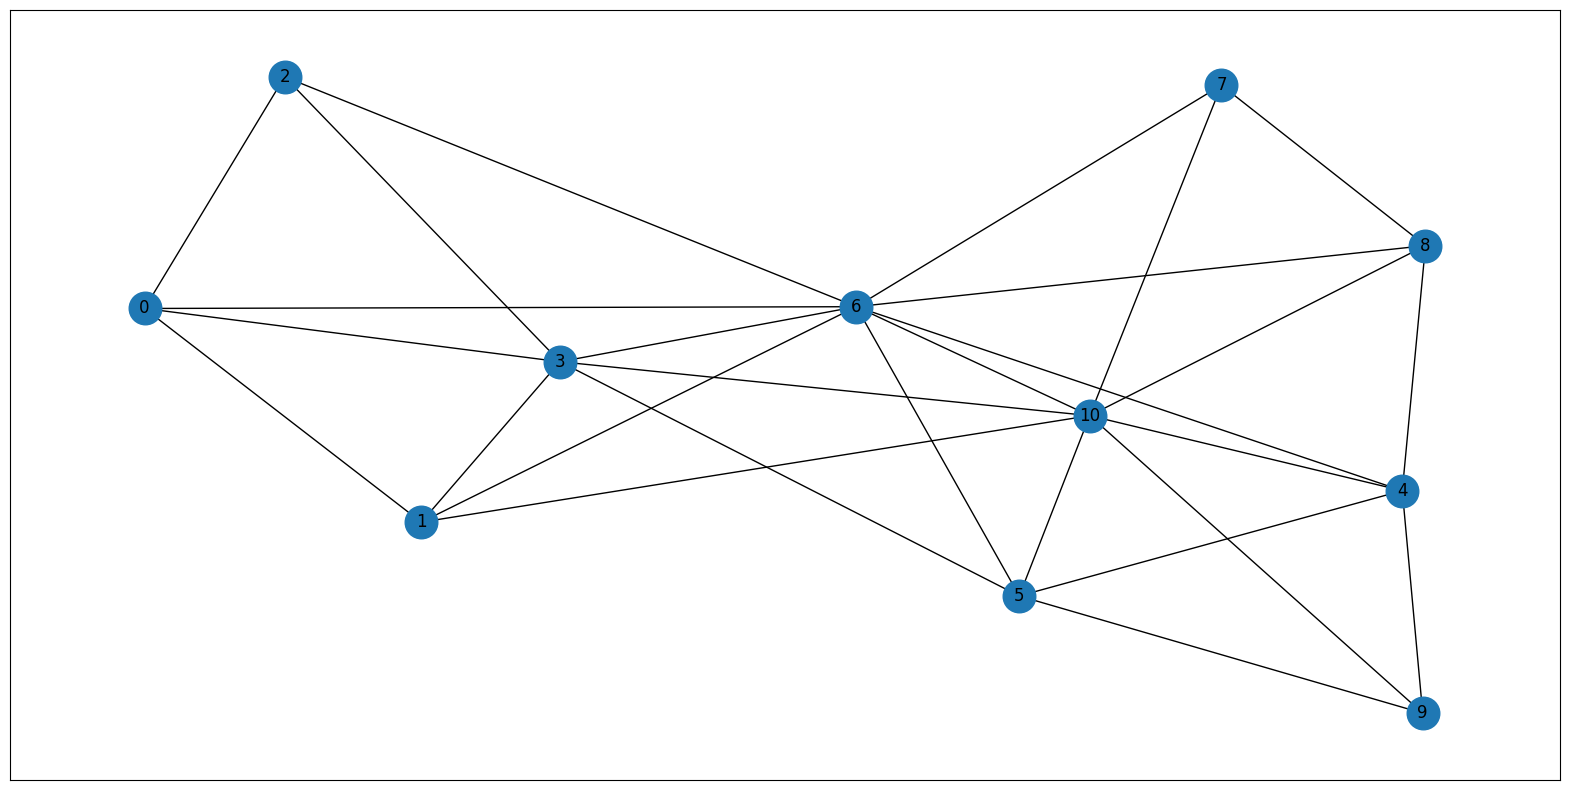

In [21]:
# everyone network - community graphs
for community in partiton_list_all:
  community_questions = ["Q" + str(i+1) for i in community]
  community_data = data[community_questions]
  G_community = create_network(community_data)
  measurements = {"Degree Centrality":[nx.degree_centrality(G_community)[i] for i in G_community.nodes()],"Eigenvector Centrality":[v for v in nx.eigenvector_centrality(G_community, max_iter=200).values()],"Betweeness Centrality":[v for v in nx.betweenness_centrality(G_community).values()]}
  results_df = pd.DataFrame.from_dict(measurements, orient='index')
  results_df.columns = G_community.nodes

  display(results_df)
  prepre_G(community_data)

0         1         2         3         4  \
Degree Centrality       0.333333  0.777778  0.444444  0.666667  0.333333   
Eigenvector Centrality  0.227606  0.409759  0.274439  0.369303  0.221229   
Betweeness Centrality   0.000000  0.134259  0.009259  0.069444  0.000000   

                               5         6         7         8         9  
Degree Centrality       0.333333  0.777778  0.888889  0.333333  0.444444  
Eigenvector Centrality  0.209858  0.403383  0.443840  0.209858  0.268062  
Betweeness Centrality   0.000000  0.134259  0.226852  0.000000  0.009259

nodes:10
edges:24


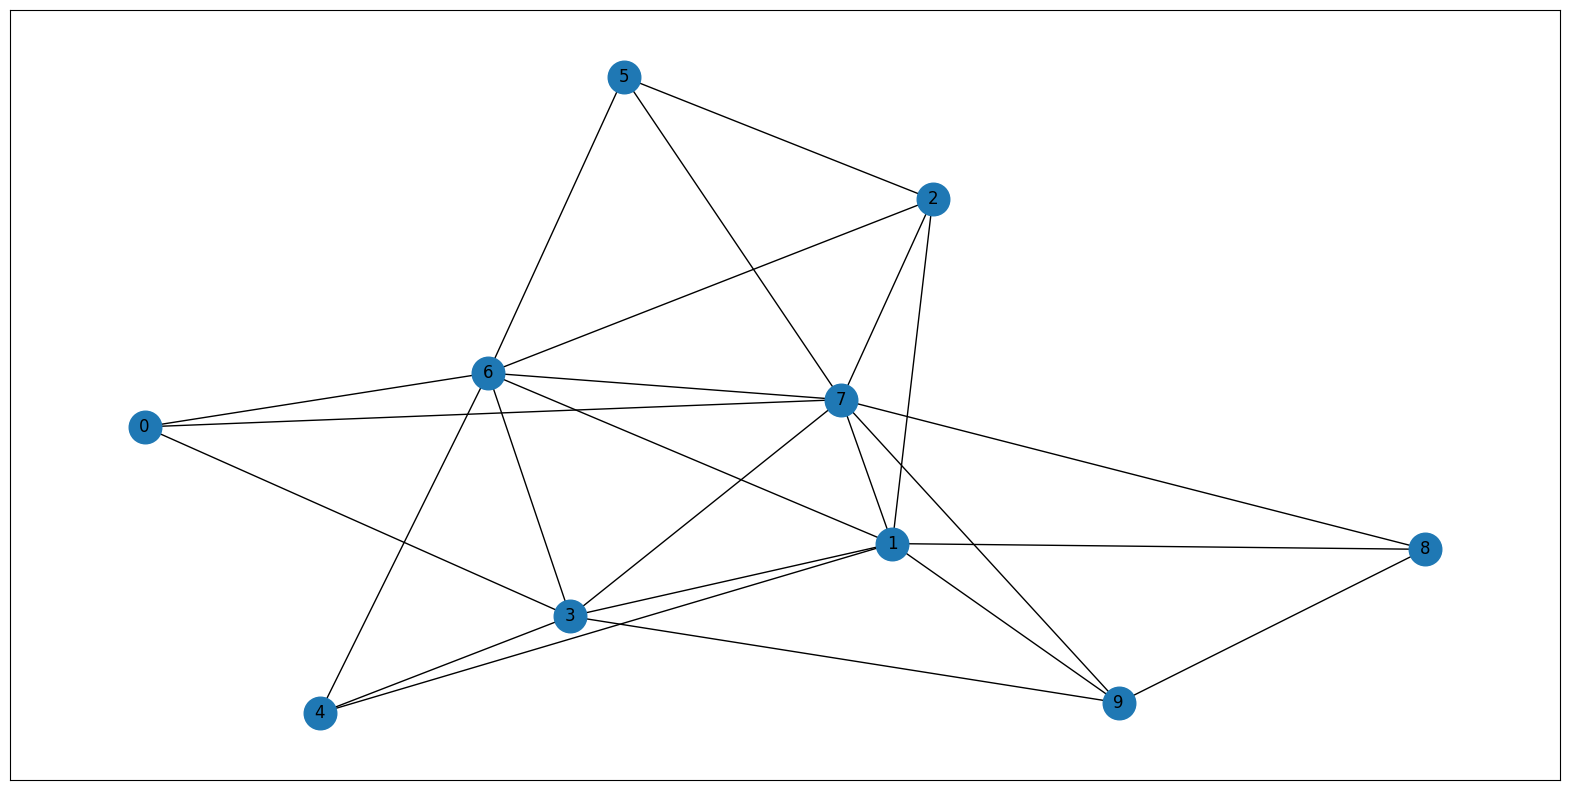

0         1         2         3         4   \
Degree Centrality       0.363636  0.272727  0.272727  0.363636  0.363636   
Eigenvector Centrality  0.228754  0.192564  0.196156  0.249430  0.244520   
Betweeness Centrality   0.006061  0.000000  0.000000  0.006061  0.006061   

                              5         6         7         8         9   \
Degree Centrality       1.000000  0.727273  0.272727  0.363636  0.636364   
Eigenvector Centrality  0.487524  0.392242  0.185558  0.237514  0.359947   
Betweeness Centrality   0.403030  0.121212  0.000000  0.006061  0.078788   

                              10        11  
Degree Centrality       0.363636  0.454545  
Eigenvector Centrality  0.220711  0.299091  
Betweeness Centrality   0.006061  0.021212

nodes:12
edges:30


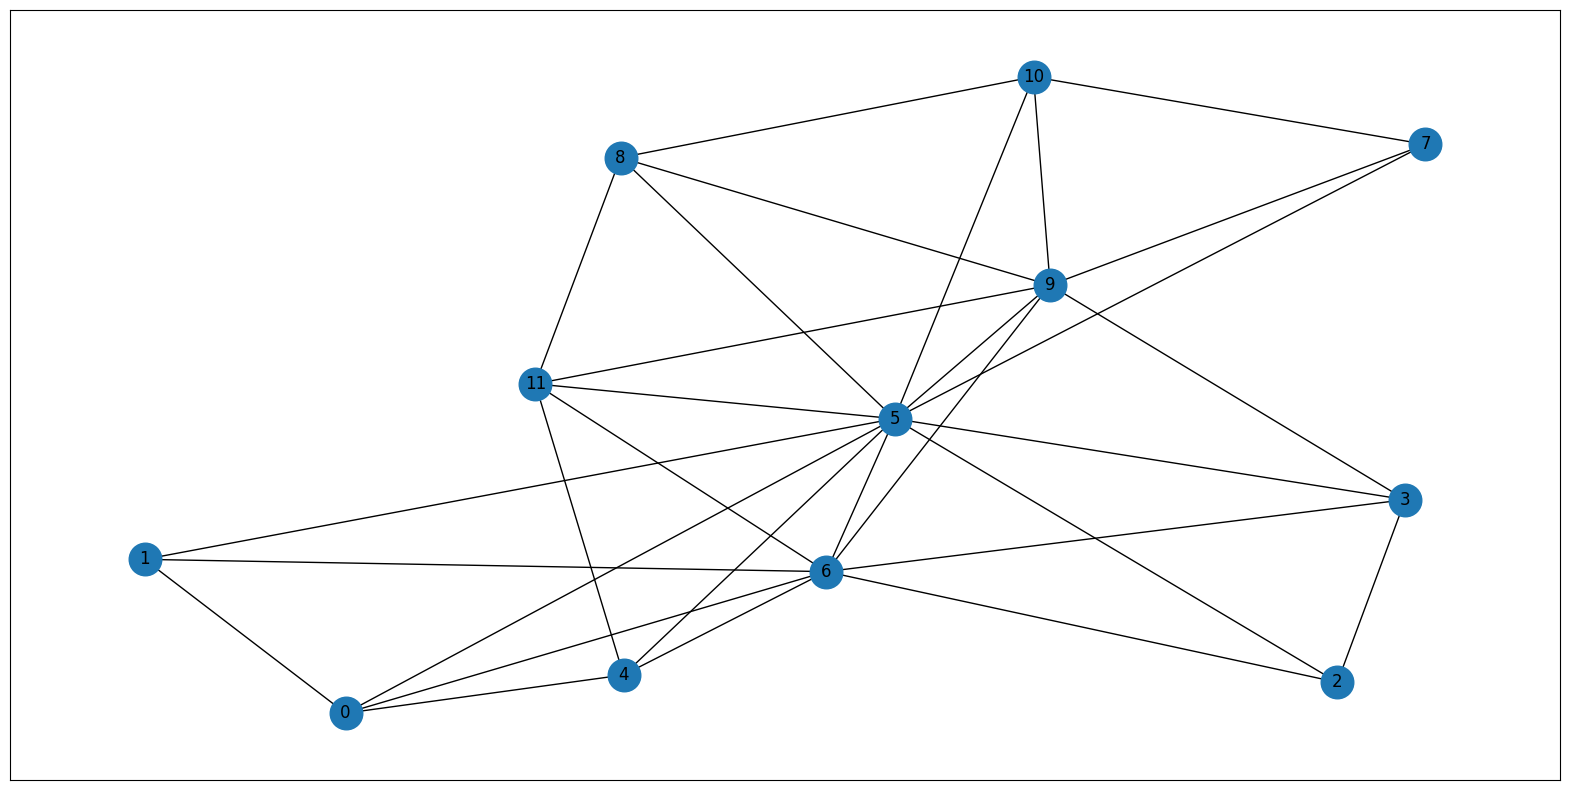

0         1         2         3         4  \
Degree Centrality       0.666667  0.500000  0.666667  1.000000  1.000000   
Eigenvector Centrality  0.367413  0.288542  0.355287  0.472248  0.472248   
Betweeness Centrality   0.022222  0.000000  0.022222  0.166667  0.166667   

                               5         6  
Degree Centrality       0.666667  0.500000  
Eigenvector Centrality  0.355287  0.288542  
Betweeness Centrality   0.022222  0.000000

nodes:7
edges:15


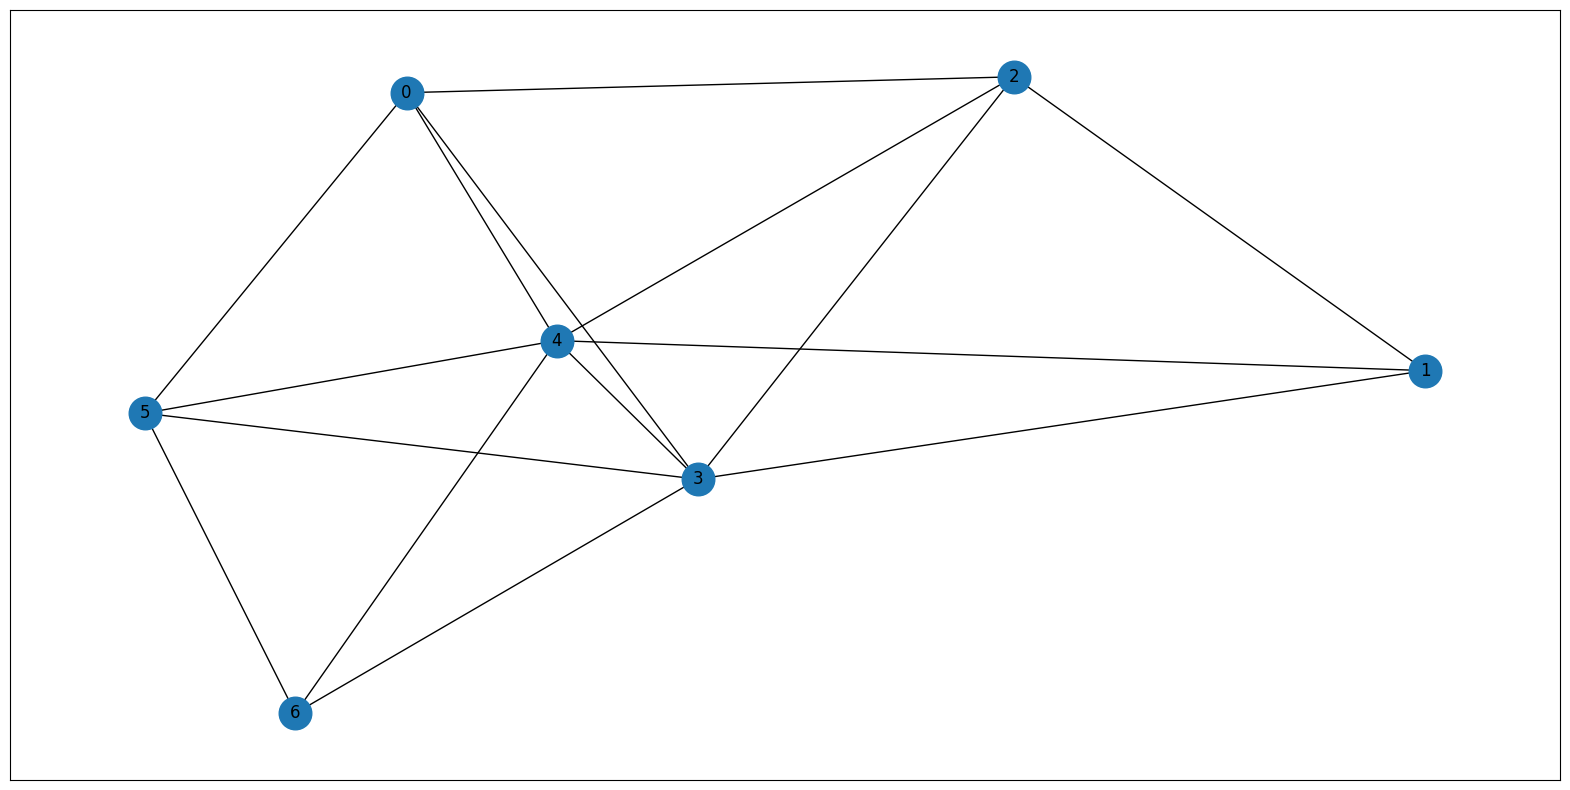

0         1         2         3         4  \
Degree Centrality       0.875000  1.000000  0.625000  0.375000  0.625000   
Eigenvector Centrality  0.438596  0.476103  0.341088  0.228875  0.350543   
Betweeness Centrality   0.154762  0.273810  0.041667  0.000000  0.041667   

                               5         6         7         8  
Degree Centrality       0.375000  0.500000  0.500000  0.375000  
Eigenvector Centrality  0.235124  0.284916  0.303830  0.246133  
Betweeness Centrality   0.000000  0.011905  0.011905  0.000000

nodes:9
edges:21


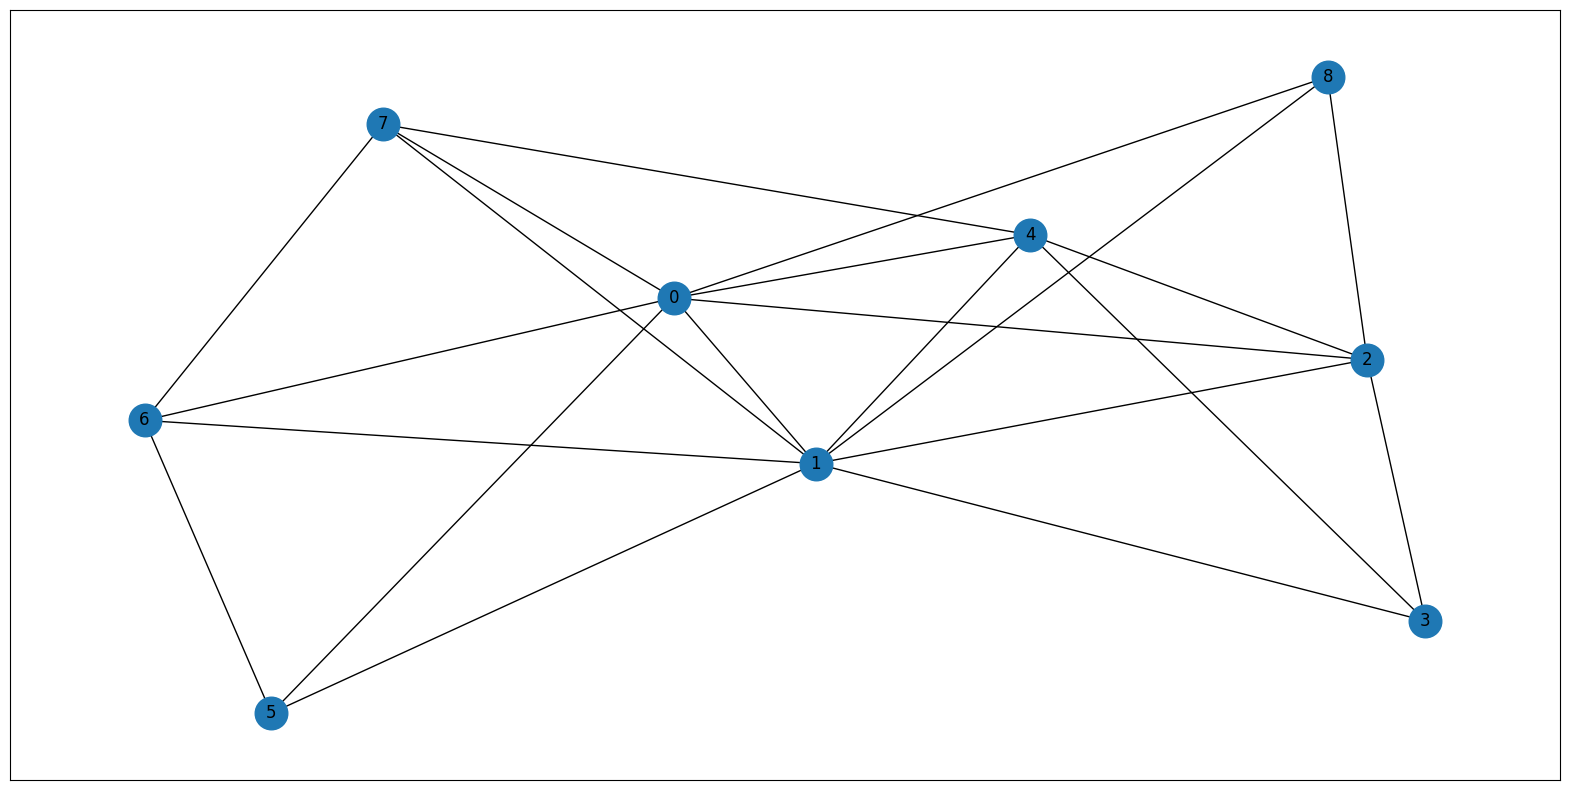

0         1         2         3         4  \
Degree Centrality       1.000000  1.000000  0.571429  0.571429  0.428571   
Eigenvector Centrality  0.472488  0.472488  0.328808  0.328808  0.260853   
Betweeness Centrality   0.206349  0.206349  0.015873  0.015873  0.000000   

                               5         6         7  
Degree Centrality       0.571429  0.428571  0.571429  
Eigenvector Centrality  0.317169  0.260853  0.317169  
Betweeness Centrality   0.015873  0.000000  0.015873

nodes:8
edges:18


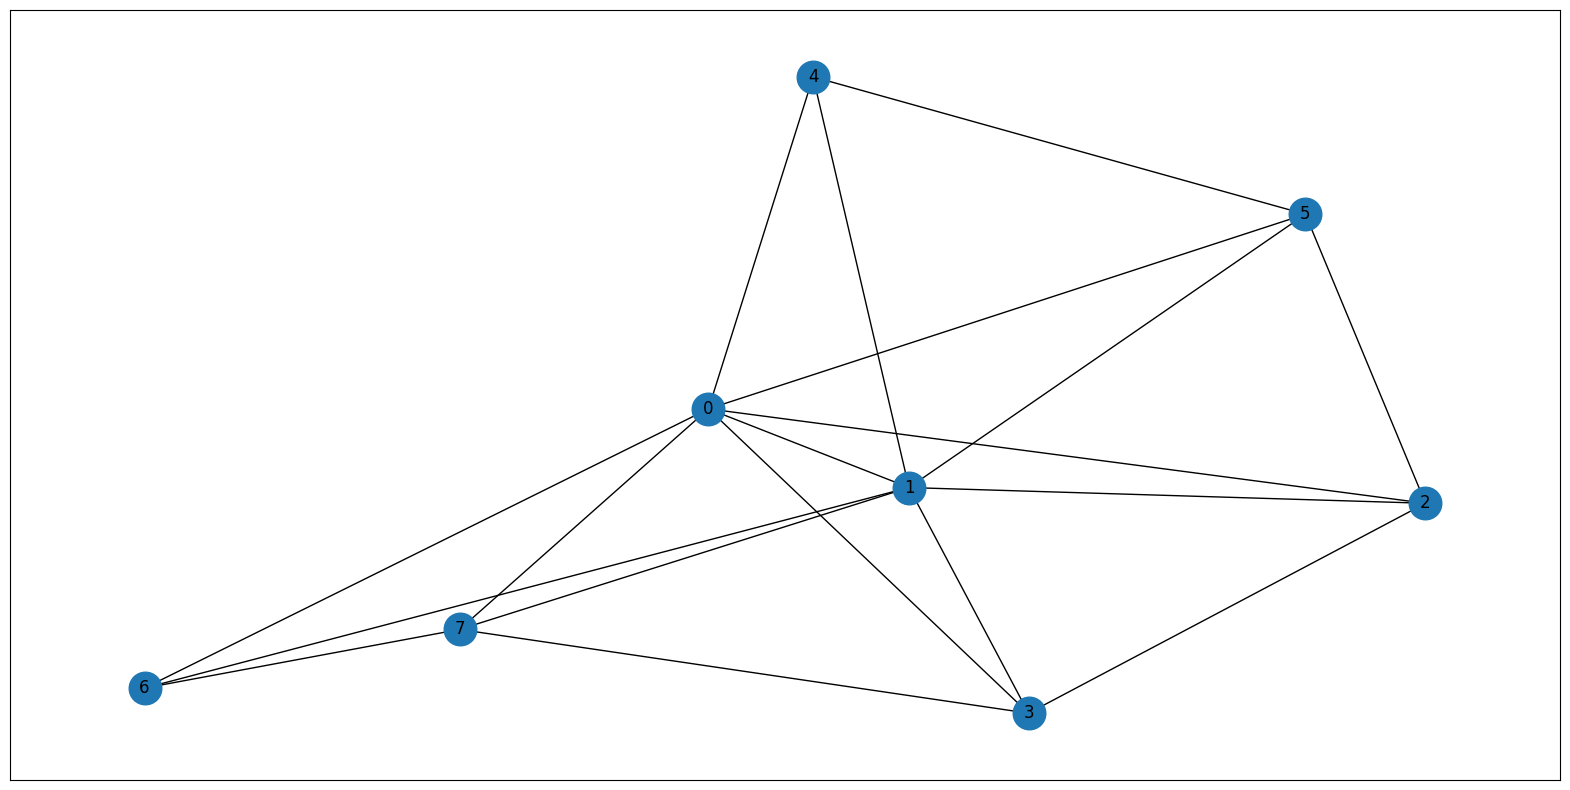

0         1         2         3         4  \
Degree Centrality       0.714286  0.714286  0.714286  0.571429  0.428571   
Eigenvector Centrality  0.394110  0.382234  0.382234  0.315883  0.247470   
Betweeness Centrality   0.055556  0.055556  0.055556  0.015873  0.000000   

                               5         6         7  
Degree Centrality       1.000000  0.571429  0.428571  
Eigenvector Centrality  0.480026  0.315883  0.247470  
Betweeness Centrality   0.277778  0.015873  0.000000

nodes:8
edges:18


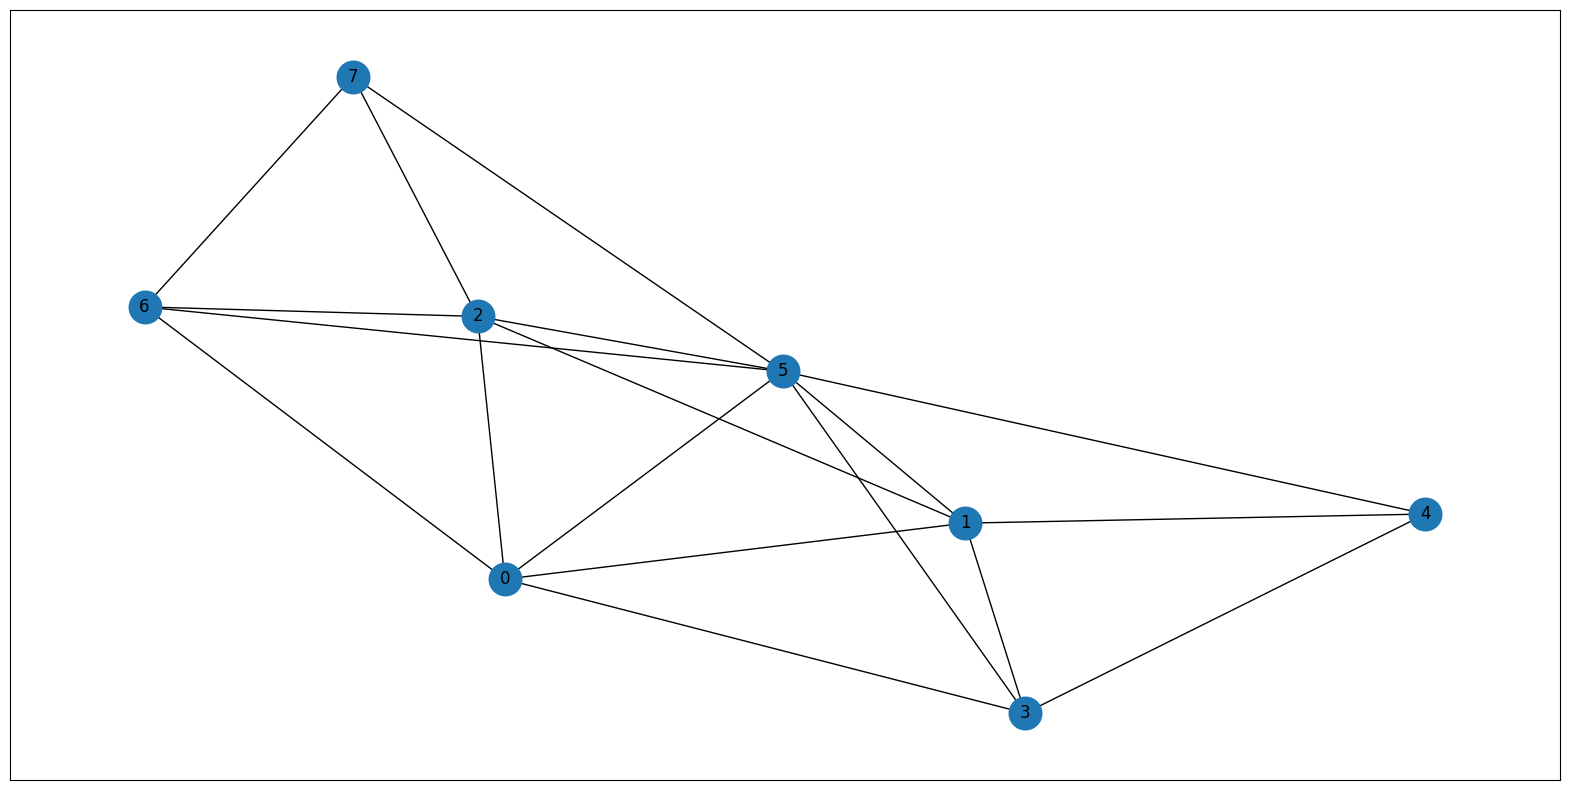

In [22]:
# divorsed network - community graphs
for community in partiton_list_div:
  community_questions = ["Q" + str(i+1) for i in community]
  community_data = data[community_questions]
  G_community = create_network(community_data)
  measurements = {"Degree Centrality":[nx.degree_centrality(G_community)[i] for i in G_community.nodes()],"Eigenvector Centrality":[v for v in nx.eigenvector_centrality(G_community, max_iter=200).values()],"Betweeness Centrality":[v for v in nx.betweenness_centrality(G_community).values()]}
  results_df = pd.DataFrame.from_dict(measurements, orient='index')
  results_df.columns = G_community.nodes

  display(results_df)
  prepre_G(community_data)

0         1         2         3         4   \
Degree Centrality       0.357143  0.214286  0.285714  0.214286  0.428571   
Eigenvector Centrality  0.219780  0.149329  0.169740  0.151567  0.262408   
Betweeness Centrality   0.045880  0.000000  0.020895  0.000000  0.074983   

                              5         6         7         8         9   \
Degree Centrality       0.214286  0.428571  0.285714  0.285714  0.285714   
Eigenvector Centrality  0.156331  0.298790  0.199368  0.211313  0.212819   
Betweeness Centrality   0.000000  0.048700  0.009383  0.010440  0.015908   

                              10        11        12        13        14  
Degree Centrality       0.714286  0.642857  0.500000  0.500000  0.214286  
Eigenvector Centrality  0.429325  0.385382  0.350737  0.312606  0.108489  
Betweeness Centrality   0.319462  0.193115  0.116270  0.090019  0.000000

nodes:15
edges:39


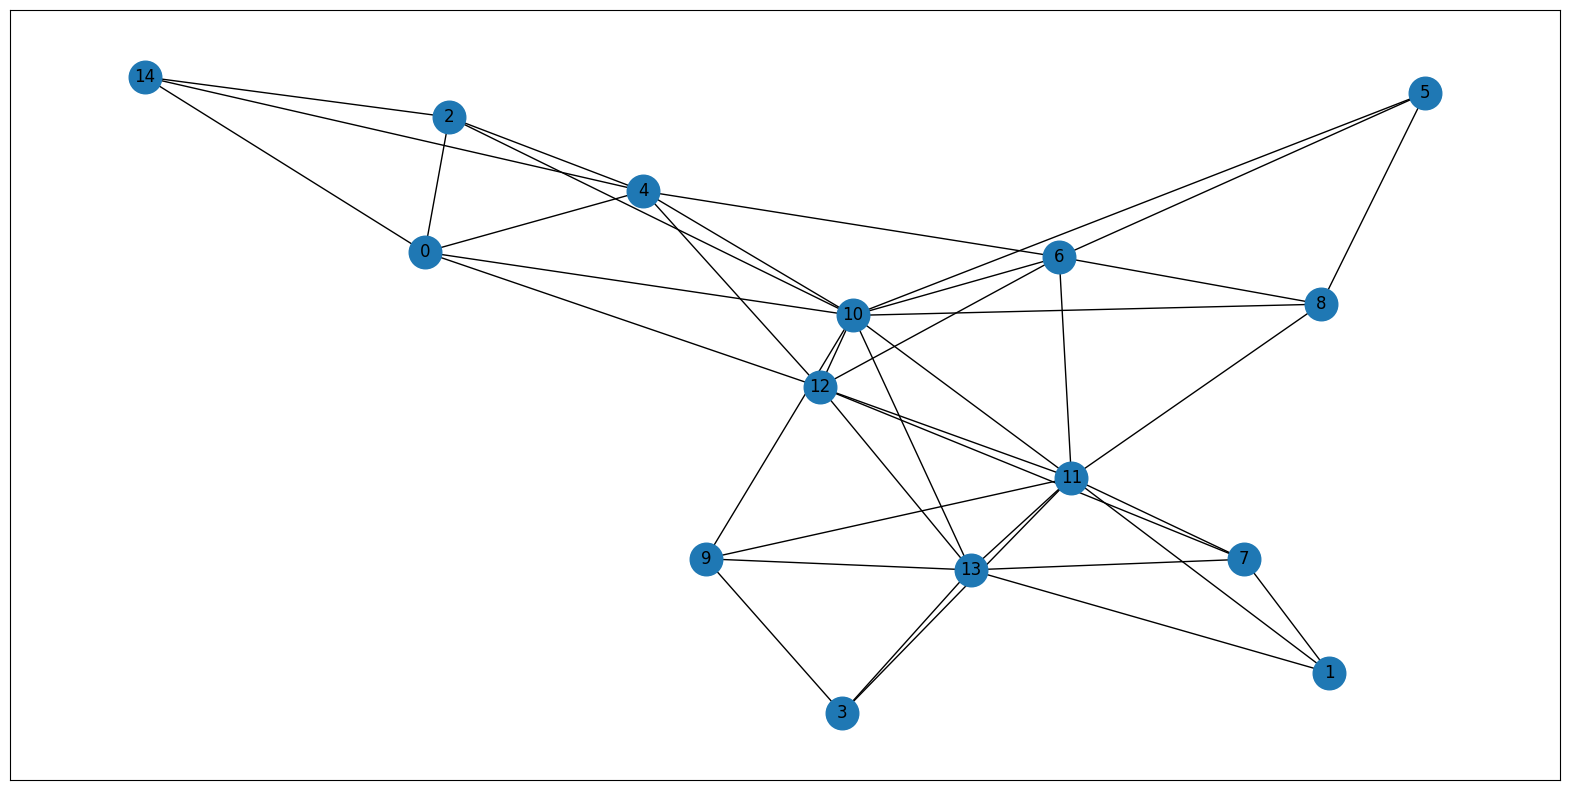

0         1         2         3         4   \
Degree Centrality       0.300000  0.300000  0.300000  0.300000  0.300000   
Eigenvector Centrality  0.188949  0.212489  0.197652  0.204129  0.212734   
Betweeness Centrality   0.000000  0.000000  0.000000  0.000000  0.000000   

                              5         6         7         8         9   \
Degree Centrality       0.500000  0.800000  0.700000  0.400000  0.800000   
Eigenvector Centrality  0.292847  0.419999  0.384017  0.253217  0.421363   
Betweeness Centrality   0.029630  0.192593  0.114815  0.011111  0.181481   

                              10  
Degree Centrality       0.700000  
Eigenvector Centrality  0.376646  
Betweeness Centrality   0.114815

nodes:11
edges:27


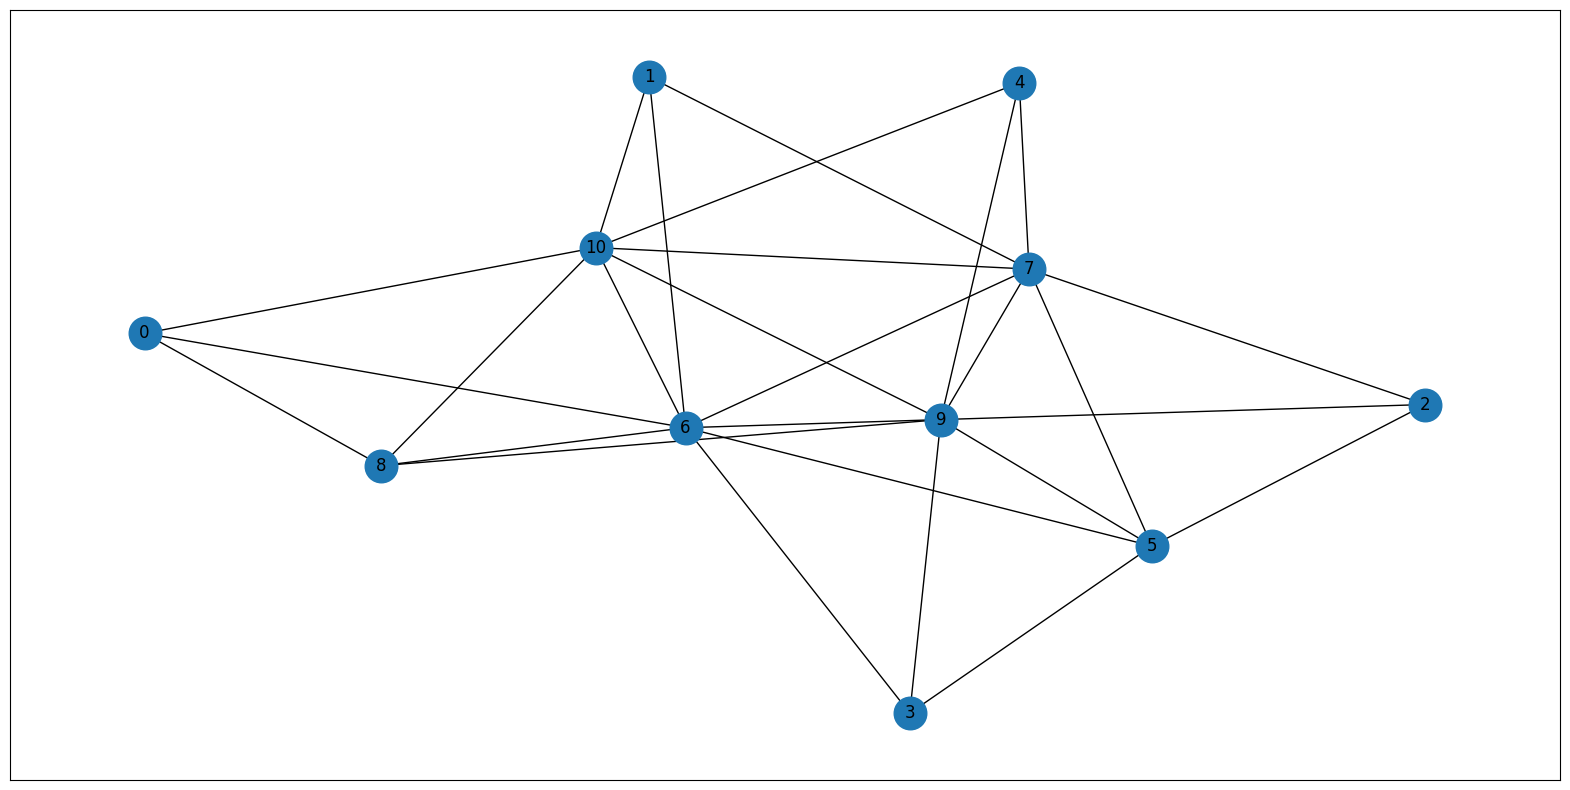

0         1         2         3         4   \
Degree Centrality       0.230769  0.615385  0.461538  0.384615  0.384615   
Eigenvector Centrality  0.160111  0.373849  0.311488  0.249466  0.229510   
Betweeness Centrality   0.000000  0.131410  0.065385  0.039530  0.030983   

                              5         6         7         8         9   \
Degree Centrality       0.230769  0.230769  0.538462  0.230769  0.307692   
Eigenvector Centrality  0.136689  0.173618  0.328706  0.155757  0.209868   
Betweeness Centrality   0.000000  0.000000  0.109829  0.000000  0.006838   

                              10        11        12        13  
Degree Centrality       0.307692  0.846154  0.384615  0.384615  
Eigenvector Centrality  0.227636  0.467676  0.260751  0.242816  
Betweeness Centrality   0.004274  0.392521  0.022222  0.017521

nodes:14
edges:36


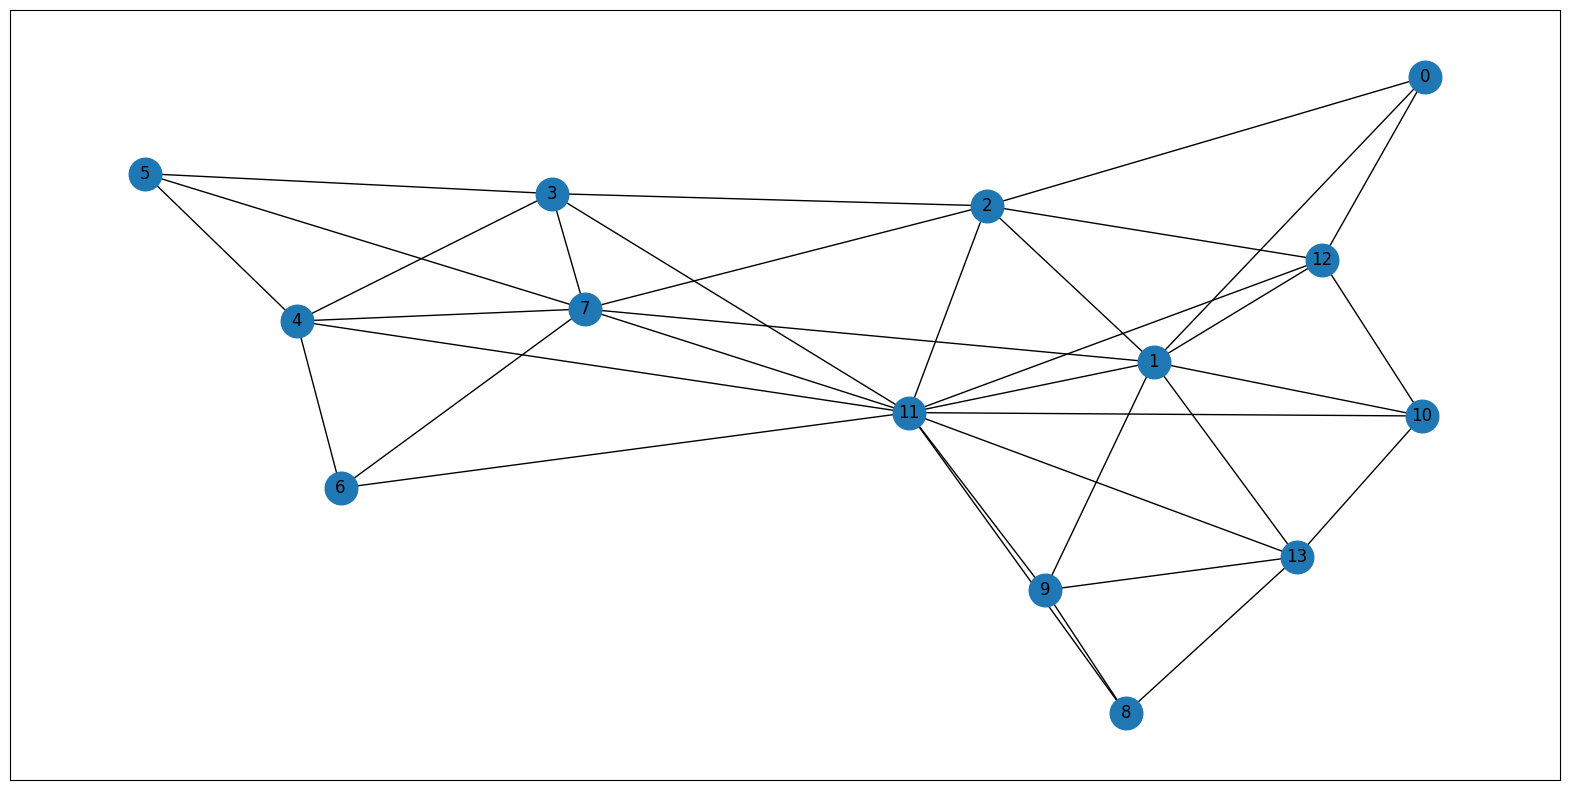

0         1         2         3         4   \
Degree Centrality       0.692308  0.538462  0.461538  0.769231  0.384615   
Eigenvector Centrality  0.391240  0.351495  0.316178  0.442400  0.259461   
Betweeness Centrality   0.163889  0.102564  0.069444  0.301709  0.017521   

                              5         6         7         8         9   \
Degree Centrality       0.461538  0.230769  0.384615  0.307692  0.230769   
Eigenvector Centrality  0.275775  0.115582  0.230148  0.179424  0.161815   
Betweeness Centrality   0.092094  0.000000  0.045085  0.020726  0.000000   

                              10        11        12        13  
Degree Centrality       0.384615  0.230769  0.230769  0.230769  
Eigenvector Centrality  0.252080  0.183102  0.184347  0.169016  
Betweeness Centrality   0.020299  0.000000  0.000000  0.000000

nodes:14
edges:36


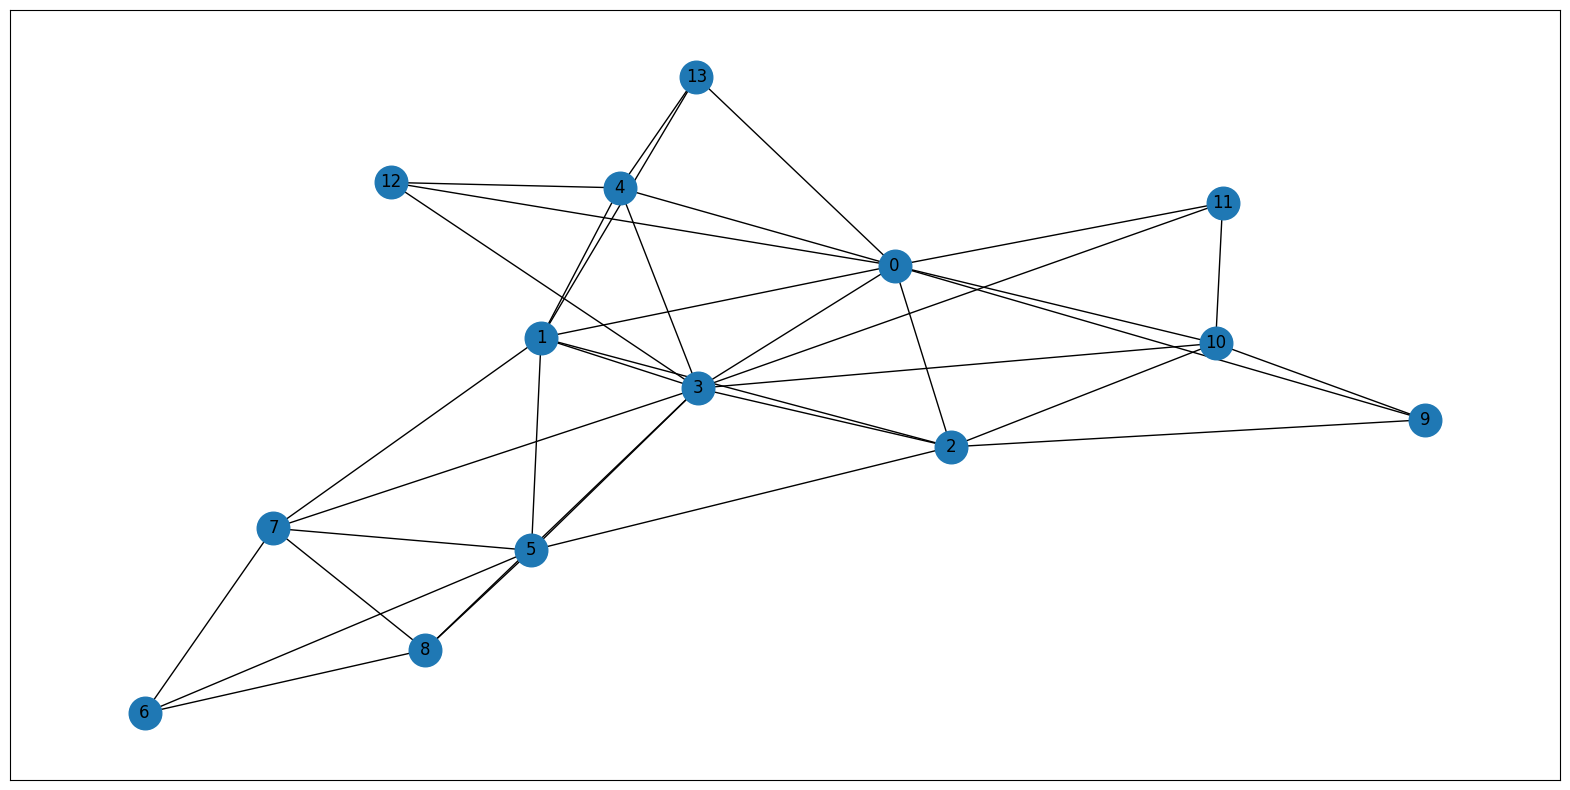

In [23]:
# married network - community graphs
for community in partiton_list_mar:
  community_questions = ["Q" + str(i+1) for i in community]
  community_data = data[community_questions]
  G_community = create_network(community_data)
  measurements = {"Degree Centrality":[nx.degree_centrality(G_community)[i] for i in G_community.nodes()],"Eigenvector Centrality":[v for v in nx.eigenvector_centrality(G_community, max_iter=200).values()],"Betweeness Centrality":[v for v in nx.betweenness_centrality(G_community).values()]}
  results_df = pd.DataFrame.from_dict(measurements, orient='index')
  results_df.columns = G_community.nodes

  display(results_df)
  prepre_G(community_data)

# Part 2

### Creating people's graphs (people are the nodes now), and the questions are only the subset that we calculate in part 1

In [24]:
print(sub1)

[2, 1, 36, 51, 42]


In [25]:
print(sub2)

[10, 11, 5, 30, 39, 43]


In [26]:
print(sub3)

[47, 20, 6, 48]


In [27]:
# concatenating the sets of significant questions from all of the networks
sub3.extend(sub1)
sub3.extend(sub2)

15
nodes:170
edges:504


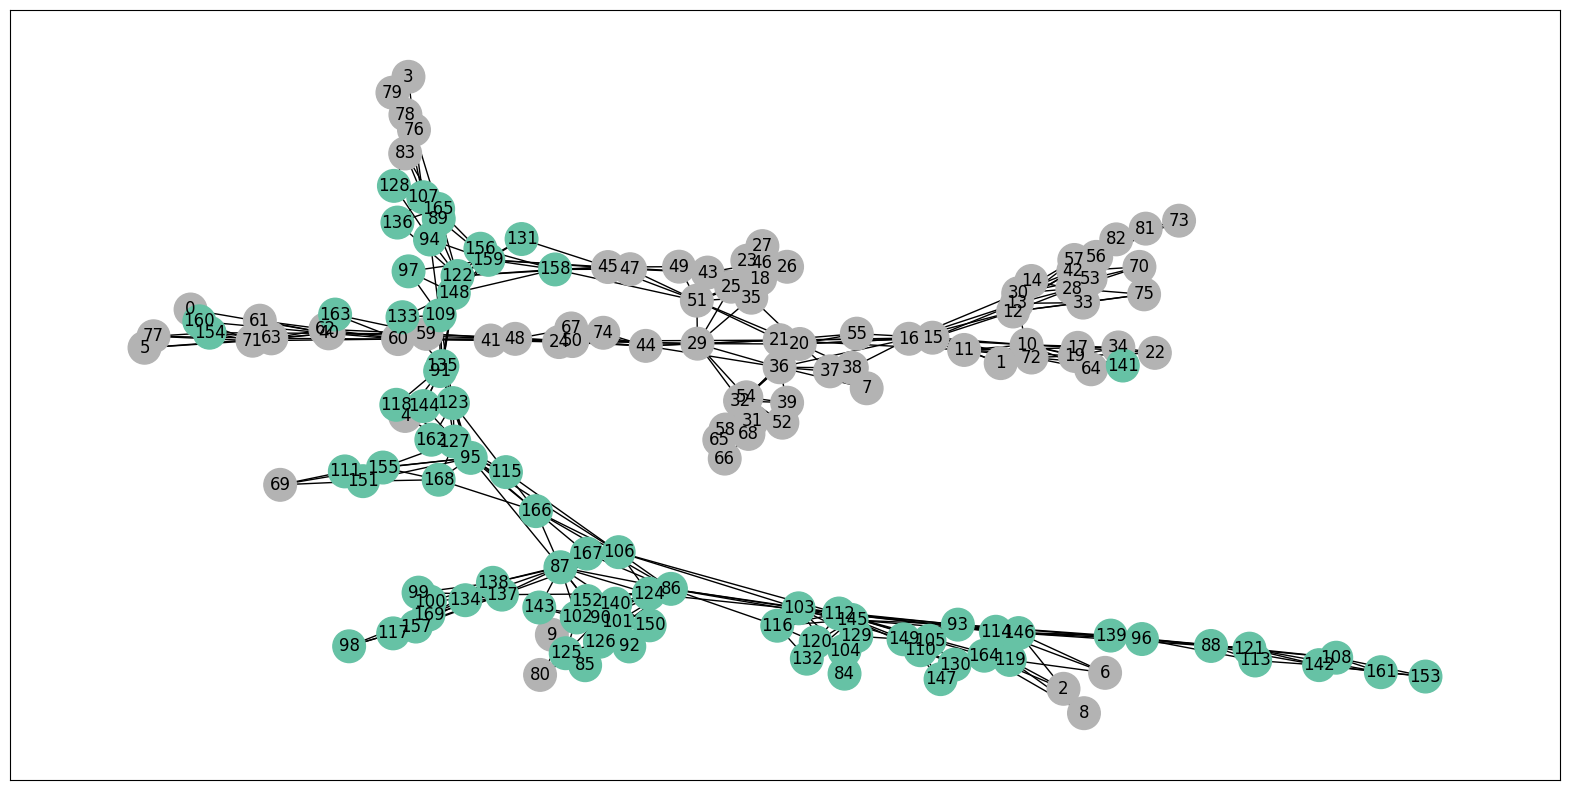

In [28]:
# creat the people in nodes graph
significant_questions = ["Q" + str(i+1) for i in sub3]
print(len(significant_questions))
second_part_data = data[significant_questions].T
prepre_G(second_part_data, coloring=labels,multi_k=5)

### Our human clustering questions

nodes:54
edges:156


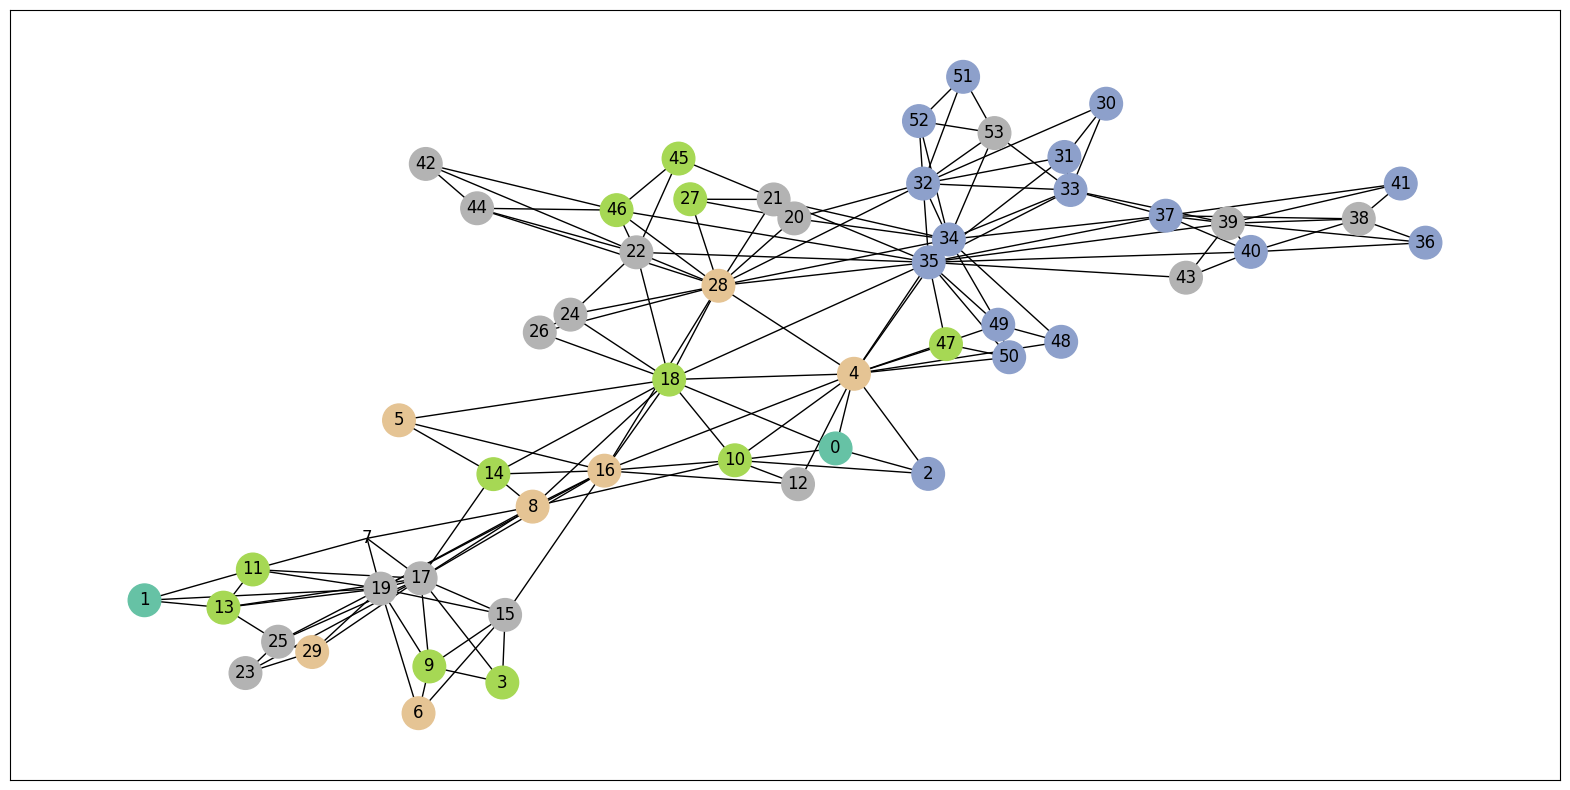

In [29]:
def color_pick(i):
  # create the coloring by the groups we divided
  group_1 = [1,2]
  group_2 = [3,31,32,33,34,37,38,41,42,49,50,51,52,53,35,36]
  group_3 = [4,10,11,14,15,19,28,46,47,48,12]
  group_4 = [5,6,7,9,17,29,30]
  group_5 = [7,13,16,18,20,21,22,23,24,25,26,27,39,40,43,44,45,54]
  groups = [group_1,group_2,group_3,group_4,group_5]
  for inx_group, group in enumerate(groups):
    if i in group:
      return inx_group

own_groups = [color_pick(i) for i in range(1,len(d.columns)+1)]
prepre_G(d, own_groups)

### Statistics: Analyze for goodness of separation between married and divorced couples


$H_(01): ACC_d - ACC_m = 0$

$H_(11): ACC_d - ACC_m \neq 0$

$H_(02): AEC_d - AEC_m = 0$

$H_(12): AEC_d - AEC_m \neq 0$

$H_(03): ASPL_d - ASPL_m = 0$

$H_(13): ASPL_d - ASPL_m \neq 0$

$H_(04): Best Modularity(G_(partB)) >Our Modularity$

$H_(14): Best Modularity(G_(partB)) <= Our Modularity$

In [30]:
part_b_G = create_network(data[significant_questions].T)


In [31]:
married_nodes = list(data[data["Divorce"]==0].index)
divorced_nodes = list(data[data["Divorce"]==1].index)
print(f"The modularity of of the partitions based on the labels is: \
{nx.community.modularity(part_b_G, [married_nodes, divorced_nodes])}")

The modularity of of the partitions based on the labels is: 0.4362762608867864


In [32]:
# Kruskal-Wallis H Test
import scipy.stats as stats
from itertools import combinations

# For ACC
married_cc = [v for v in nx.clustering(part_b_G, nodes=married_nodes).values()]
married_cc = np.array(married_cc)

divorced_cc = [v for v in nx.clustering(part_b_G, nodes=divorced_nodes).values()]
divorced_cc = np.array(divorced_cc)

# For AEC
married_ec = [v for v in nx.eigenvector_centrality(part_b_G.subgraph(*[married_nodes]), max_iter=200).values()]
married_ec = np.array(married_ec)

divorced_ec = [v for v in nx.eigenvector_centrality(part_b_G.subgraph(*[divorced_nodes]), max_iter=200).values()]
divorced_ec = np.array(divorced_ec)

# For ASPL
pairs_married = list(combinations(married_nodes, 2))
pairs_divorced = list(combinations(divorced_nodes, 2))
married_spl = [nx.shortest_path_length(part_b_G, pairs_married[i][0],pairs_married[i][1])
                for i in range(len(pairs_married))]
married_spl = np.array(married_spl)

divorced_spl = [nx.shortest_path_length(part_b_G, pairs_divorced[i][0],pairs_divorced[i][1])
                for i in range(len(pairs_divorced))]
divorced_spl = np.array(divorced_spl)

#For modularity
modularity_values = generate_modularity_values(part_b_G)


results_part_b = {
    "Kruskal-Wallis H Test Pvalue": [stats.kruskal(married_cc, divorced_cc).pvalue,
                                     stats.kruskal(married_ec, divorced_ec).pvalue,
                                     stats.kruskal(married_spl, divorced_spl).pvalue,
                                     ],
}

results_part_b_df = pd.DataFrame.from_dict(results_part_b, orient='index')
results_part_b_df.columns = ["ACC", "AEC", "ASPL"]
results_part_b_df

ACC       AEC          ASPL
Kruskal-Wallis H Test Pvalue  0.484996  0.866341  6.245275e-14

In [33]:
# Caomputing the pvale of the T test for the 4th hypothesis test

print(f"Pvalue of T test for modularity: {stats.ttest_1samp(a=modularity_values, popmean=nx.community.modularity(part_b_G, [married_nodes, divorced_nodes]) , alternative='less').pvalue}")

Pvalue of T test for modularity: 1.0
